In [27]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import re

In [28]:
def extract_person_info(person_str, role=True):
    # Remove any titles enclosed in quotes
    person_str = re.sub(r': ".*?"', '', person_str)

    # Helper function to process individual dates
    def process_date(date_str):
        if not date_str:
            return None, False  # Return None and BC indicator as False
        date_str = date_str.strip()
        is_bc = False

        # Remove 'u. ' prefix indicating uncertainty
        date_str = re.sub(r'^u\. ?', '', date_str)

        # Check for 'e. Kr' (BC dates) and 'p. Kr' (AD dates)
        bc_match = re.search(r'e\. ?Kr\.?', date_str, re.IGNORECASE)
        ad_match = re.search(r'p\. ?Kr\.?', date_str, re.IGNORECASE)
        if bc_match:
            is_bc = True
        elif ad_match:
            is_bc = False  # Explicitly marked as AD

        # Remove 'e. Kr' or 'p. Kr' suffixes
        date_str = re.sub(r'(e\. ?Kr\.?|p\. ?Kr\.?)', '', date_str, flags=re.IGNORECASE).strip()

        # Convert date string to integer
        try:
            date_int = int(date_str)
            return date_int, is_bc
        except ValueError:
            return None, False  # Return None if the date is not a valid integer

    # Regular expression pattern to match the entire string
    # Matches: Name (birth_date - death_date) [role]
    pattern = r'^(.+?)\s*\((.*?)\)\s*(?:\[(.+?)\])?$'

    match = re.match(pattern, person_str)
    if match:
        name, date_range, role_str = match.groups()
        name = name.strip()
        role_str = role_str.strip().lower() if role_str and role else None

        # Split the date range into birth and death dates
        birth_date_str, _, death_date_str = date_range.partition('-')

        # Process birth and death dates
        birth_date, birth_is_bc = process_date(birth_date_str)
        death_date, death_is_bc = process_date(death_date_str)

        # If the death date is BC and the birth date is not explicitly AD, assume birth date is BC
        if death_is_bc and not birth_is_bc and birth_date is not None:
            birth_is_bc = True
            birth_date = -birth_date
        elif birth_is_bc and birth_date is not None:
            birth_date = -birth_date

        # If the death date is BC, make it negative
        if death_is_bc and death_date is not None:
            death_date = -death_date

        if role:
            return (name, birth_date, death_date, role_str)
        else:
            return (name, birth_date, death_date)

    # Handle cases with only the name and optional role
    # Matches: Name [role] or Name
    pattern_name_role = r'^(.+?)\s*(?:\[(.+?)\])?$'
    match = re.match(pattern_name_role, person_str)
    if match:
        name, role_str = match.groups()
        name = name.strip()
        role_str = role_str.strip().lower() if role_str and role else None

        if role:
            return (name, None, None, role_str)
        else:
            return (name, None, None)

    # Return None values if no pattern matched
    if role:
        return (None, None, None, None)
    else:
        return (None, None, None)

def create_graph(erb, min_year, max_year, id_to_int=False):
    """
    Create a directed graph from the 'erb' DataFrame filtered by publication year range.
    Edges are directed from translators to authors.

    Parameters:
    - erb: pd.DataFrame containing publication data.
    - min_year: Minimum publication year.
    - max_year: Maximum publication year.

    Returns:
    - G: A NetworkX DiGraph with nodes and edges representing authors and their collaborations.
    """
    import networkx as nx
    import itertools
    from collections import Counter
    from tqdm import tqdm

    # Helper function to process genres
    def process_genres(genre_str, to_remove=["ilukirjandus", "e-raamatud"]):
        if isinstance(genre_str, str):
            genres = genre_str.split("; ")
            genres = [genre.split(" [")[0].split(" (")[0] for genre in genres]
            if to_remove:
                genres = [genre for genre in genres if genre not in to_remove]
            return genres
        return [None]

    # Helper function to generate node identifiers
    def get_node_identifier(name, birth_date, death_date):
        if birth_date is not None and death_date is not None:
            return f"{name} ({birth_date}-{death_date})"
        elif birth_date is not None:
            return f"{name} ({birth_date}-)"
        elif death_date is not None:
            return f"{name} (-{death_date})"
        return name

    # Filter the DataFrame using query for better readability
    df = erb.query(
        'publication_date_cleaned >= @min_year and publication_date_cleaned <= @max_year and creator.notna() and contributor.notna()'
    )

    # Initialize a directed graph
    G = nx.DiGraph()
    
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        # Extract and process person data from the dataframe row
        creators = [extract_person_info(name) for name in row['creator'].split('; ') if name.strip()]
        contributors = [extract_person_info(name) for name in row['contributor'].split('; ') if name.strip()]
        all_contributors = creators + contributors
        authors = [person for person in all_contributors if person[3] == "autor"]
        translators = [person for person in all_contributors if person[3] == "tõlkija"]
        
        if authors and translators:
            people = authors + translators
            # Get node identifiers for authors and translators
            author_names = [get_node_identifier(p[0], p[1], p[2]) for p in authors]
            translator_names = [get_node_identifier(p[0], p[1], p[2]) for p in translators]
            pairs = itertools.product(translator_names, author_names)  # Edges from translators to authors
            current_year = row['publication_date_cleaned']  # The year of the current publication
            work_info = (row['title'], current_year)
            language = row["language_original"]
            genres = set(process_genres(row["genre_keyword"]))
            
            # Update edges from translators to authors
            for node_u, node_v in pairs:
                if G.has_edge(node_u, node_v):
                    edge = G.edges[node_u, node_v]
                    edge['weight'] += 1
                    edge['works'].append(work_info)
                    edge['languages'].append(language)
                    edge['genres'].update(genres)
                    edge['activity_end'] = max(edge['activity_end'], current_year)
                    edge['activity_start'] = min(edge['activity_start'], current_year)
                else:
                    G.add_edge(
                        node_u, node_v,
                        weight=1,
                        works=[work_info],
                        languages=[language],
                        genres=genres,
                        activity_start=current_year,
                        activity_end=current_year
                    )
                        
            # Process nodes (authors and translators)
            for person in people:
                name, birth_date, death_date, role = person if len(person) == 4 else (*person, None)
                node_id = get_node_identifier(name, birth_date, death_date)

                current_node = G.nodes.get(node_id, {})

                # Update node attributes once
                current_node.update({
                    "label": node_id,
                    #'label_short': name,
                    'date_of_birth': birth_date or 0,
                    'date_of_death': death_date or 0,
                })

                # Update role counts for "autor" and "tõlkija"
                if role == "autor":
                    current_node["autor_count"] = current_node.get("autor_count", 0) + 1
                elif role == "tõlkija":
                    current_node["tõlkija_count"] = current_node.get("tõlkija_count", 0) + 1

                # Update activity years
                current_node['activity_start'] = min(
                    current_node.get('activity_start', current_year), current_year
                )
                current_node['activity_end'] = max(
                    current_node.get('activity_end', current_year), current_year
                )

                G.add_node(node_id, **current_node)
                    
    # Remove self-loops (if any)
    G.remove_edges_from(nx.selfloop_edges(G))

    # Remove isolated nodes (those with no edges):
    isolated_nodes = [n for n, deg in G.degree() if deg == 0]
    G.remove_nodes_from(isolated_nodes)

    print("Updating node attributes")
    # Calculate and store the total_count and main_role for each node
    for node_id, attributes in tqdm(G.nodes(data=True)):
        # Calculate total role counts and determine the main role
        autor_count = attributes.get("autor_count", 0)
        tõlkija_count = attributes.get("tõlkija_count", 0)
        total_count = autor_count + tõlkija_count
        
        G.nodes[node_id]["total_count"] = total_count
        G.nodes[node_id]["main_role"] = "autor" if autor_count >= tõlkija_count else "tõlkija"
        
        # Set 'author_lang' based on the main role
        if G.nodes[node_id]["main_role"] == "autor":
            name = attributes.get('label_short', node_id)  # Use short label
            author_lang_series = df[df['creator'].str.contains(name, regex=False)]['language_original']
            author_lang = author_lang_series.mode()
            G.nodes[node_id]["author_lang"] = author_lang.iloc[0] if not author_lang.empty else "und"
        elif G.nodes[node_id]["main_role"] == "tõlkija":
            G.nodes[node_id]["author_lang"] = "tõlkija"
    
    print("Updating node attributes")
    # Update edge attributes
    for edge in tqdm(G.edges):
        edge_data = G.edges[edge]
        language_counter = Counter(edge_data["languages"])
        edge_data["language"] = language_counter.most_common(1)[0][0]
        edge_data["genres"] = list(edge_data["genres"])  # Convert set to list for export
    
    # Optionally, replace node IDs with integers for better GEXF compatibility
    if id_to_int:
        G = nx.convert_node_labels_to_integers(G)

    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

In [29]:
def analyze_graph(G):
    stats = {}

    # Basic metrics
    stats["nodes"] = len(G.nodes)
    stats["edges"] = len(G.edges)
    stats["density"] = nx.density(G)

    # Average degree
    stats["average_degree"] = sum(dict(G.degree()).values()) / len(G.nodes)
    stats["average_translator_degree"] = sum(d for n, d in G.degree() if G.nodes[n].get("main_role") == "tõlkija") / sum(1 for n in G.nodes if G.nodes[n].get("main_role") == "tõlkija")
    stats["average_author_degree"] = sum(d for n, d in G.degree() if G.nodes[n].get("main_role") != "tõlkija") / sum(1 for n in G.nodes if G.nodes[n].get("main_role") != "tõlkija")
    # Convert to undirected for subsequent calculations
    G = nx.to_undirected(G)

    # Clustering
    stats["average_clustering"] = nx.average_clustering(G)

    # Connectivity
    stats["connected_components"] = nx.number_connected_components(G)

    # Largest Connected Component
    largest_cc = max(nx.connected_components(G), key=len)
    largest_cc_size = len(largest_cc)
    stats["largest_cc_size"] = largest_cc_size
    stats["largest_cc_proportion"] = largest_cc_size / len(G.nodes) if len(G.nodes) > 0 else 0

    # Subgraph of Largest Connected Component
    #largest_cc_subgraph = G.subgraph(largest_cc)
    #stats["largest_cc_average_shortest_path_length"] = nx.average_shortest_path_length(largest_cc_subgraph)

    # Assortativity
    stats["degree_assortativity"] = nx.degree_assortativity_coefficient(G) if len(G.nodes) > 1 else None
    
    return stats

In [34]:
def composite_plot(stats_list, time_ranges):
    """
    Creates a composite plot showing the evolution of graph metrics over time.

    Parameters:
    - stats_list: List of dictionaries with graph statistics.
    - time_ranges: List of time ranges corresponding to the stats (e.g., ["1900-1910", "1910-1920"]).
    """
    # Extract all keys from the stats (assuming all dictionaries have the same keys)
    stat_keys = list(stats_list[0].keys())

    # Determine grid size for subplots
    n_metrics = len(stat_keys)
    n_cols = 3  # Fixed number of columns
    n_rows = math.ceil(n_metrics / n_cols)  # Number of rows to fit all metrics

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    axes = axes.flatten()  # Flatten axes for easier iteration

    for i, key in enumerate(stat_keys):
        ax = axes[i]
        # Extract values for the current metric
        values = [stats[key] for stats in stats_list]

        # Plot the values over time
        ax.plot(time_ranges, values, marker="o", linestyle="-")
        ax.set_title(key.replace("_", " ").capitalize())
        ax.set_xlabel("Decade")
        ax.set_ylabel(key.replace("_", " ").capitalize())

        # Apply ylim=0 where applicable
        if key in ["nodes", "edges", "density", "average_in_degree", "average_out_degree", "largest_cc_size", "largest_cc_proportion", "connected_components"]:
            ax.set_ylim(0)

        # Rotate x-ticks for readability
        ax.set_xticks(time_ranges); ax.set_xticklabels([t.split("-")[0] for t in time_ranges], rotation=45)
        ax.tick_params(axis='x', rotation=45)

    # Turn off unused subplots (if any)
    for j in range(len(stat_keys), len(axes)):
        axes[j].axis("off")

    # Adjust layout
    fig.tight_layout()
    plt.show()


In [21]:
erb_main = pd.read_parquet("../data/raw/erb_all_books.parquet")
df = erb_main.query('is_fiction == True and language == "est" and language_original.notna()')

In [31]:
timeranges = [(1900, 1910), (1910, 1920), (1920, 1930), (1930, 1940), (1940, 1950), (1950, 1960), (1960, 1970), (1970, 1980), (1980, 1990), (1990, 2000), (2000, 2010), (2010, 2020)]
timeranges_str = [f"{start}-\n{end}" for start, end in timeranges]
graphs = [create_graph(df, start_year, end_year, id_to_int=False) for start_year, end_year in timeranges]

100%|██████████| 476/476 [00:00<00:00, 3939.91it/s]


Updating node attributes


100%|██████████| 514/514 [00:02<00:00, 250.31it/s]


Updating node attributes


100%|██████████| 419/419 [00:00<00:00, 105158.77it/s]


Created graph with 514 nodes and 419 edges


100%|██████████| 452/452 [00:00<00:00, 2533.01it/s]


Updating node attributes


100%|██████████| 456/456 [00:01<00:00, 236.07it/s]


Updating node attributes


100%|██████████| 376/376 [00:00<00:00, 75198.28it/s]


Created graph with 456 nodes and 376 edges


100%|██████████| 884/884 [00:00<00:00, 3005.70it/s]


Updating node attributes


100%|██████████| 801/801 [00:02<00:00, 274.85it/s]


Updating node attributes


100%|██████████| 744/744 [00:00<00:00, 248373.30it/s]


Created graph with 801 nodes and 744 edges


100%|██████████| 1069/1069 [00:00<00:00, 6556.74it/s]


Updating node attributes


100%|██████████| 777/777 [00:01<00:00, 411.11it/s]


Updating node attributes


100%|██████████| 740/740 [00:00<00:00, 246214.89it/s]


Created graph with 777 nodes and 740 edges


100%|██████████| 360/360 [00:00<00:00, 5805.56it/s]


Updating node attributes


100%|██████████| 369/369 [00:01<00:00, 328.10it/s]


Updating node attributes


100%|██████████| 304/304 [00:00<00:00, 75937.61it/s]


Created graph with 369 nodes and 304 edges


100%|██████████| 758/758 [00:00<00:00, 5807.06it/s]


Updating node attributes


100%|██████████| 774/774 [00:02<00:00, 347.49it/s]


Updating node attributes


100%|██████████| 711/711 [00:00<00:00, 83916.77it/s]


Created graph with 774 nodes and 711 edges


100%|██████████| 1019/1019 [00:00<00:00, 5170.24it/s]


Updating node attributes


100%|██████████| 1102/1102 [00:03<00:00, 330.57it/s]


Updating node attributes


100%|██████████| 1108/1108 [00:00<00:00, 276180.47it/s]


Created graph with 1102 nodes and 1108 edges


100%|██████████| 991/991 [00:00<00:00, 4107.65it/s]


Updating node attributes


100%|██████████| 1135/1135 [00:03<00:00, 318.79it/s]


Updating node attributes


100%|██████████| 1091/1091 [00:00<00:00, 84669.92it/s]


Created graph with 1135 nodes and 1091 edges


100%|██████████| 1081/1081 [00:00<00:00, 6489.52it/s]


Updating node attributes


100%|██████████| 1210/1210 [00:03<00:00, 369.06it/s]


Updating node attributes


100%|██████████| 1124/1124 [00:00<00:00, 225213.67it/s]


Created graph with 1210 nodes and 1124 edges


100%|██████████| 2939/2939 [00:00<00:00, 4490.62it/s]


Updating node attributes


100%|██████████| 2466/2466 [00:07<00:00, 343.44it/s]


Updating node attributes


100%|██████████| 2597/2597 [00:00<00:00, 216054.58it/s]


Created graph with 2466 nodes and 2597 edges


100%|██████████| 5510/5510 [00:01<00:00, 4886.80it/s]


Updating node attributes


100%|██████████| 3849/3849 [00:18<00:00, 205.14it/s]


Updating node attributes


100%|██████████| 4377/4377 [00:00<00:00, 74488.33it/s]


Created graph with 3849 nodes and 4377 edges


100%|██████████| 9465/9465 [00:02<00:00, 3675.69it/s]


Updating node attributes


100%|██████████| 4337/4337 [00:30<00:00, 144.22it/s]


Updating node attributes


100%|██████████| 4923/4923 [00:00<00:00, 153880.13it/s]

Created graph with 4337 nodes and 4923 edges


In [32]:
stats_list = []
for g in tqdm(graphs):
    stats_list.append(analyze_graph(g))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:01<00:00,  7.32it/s]


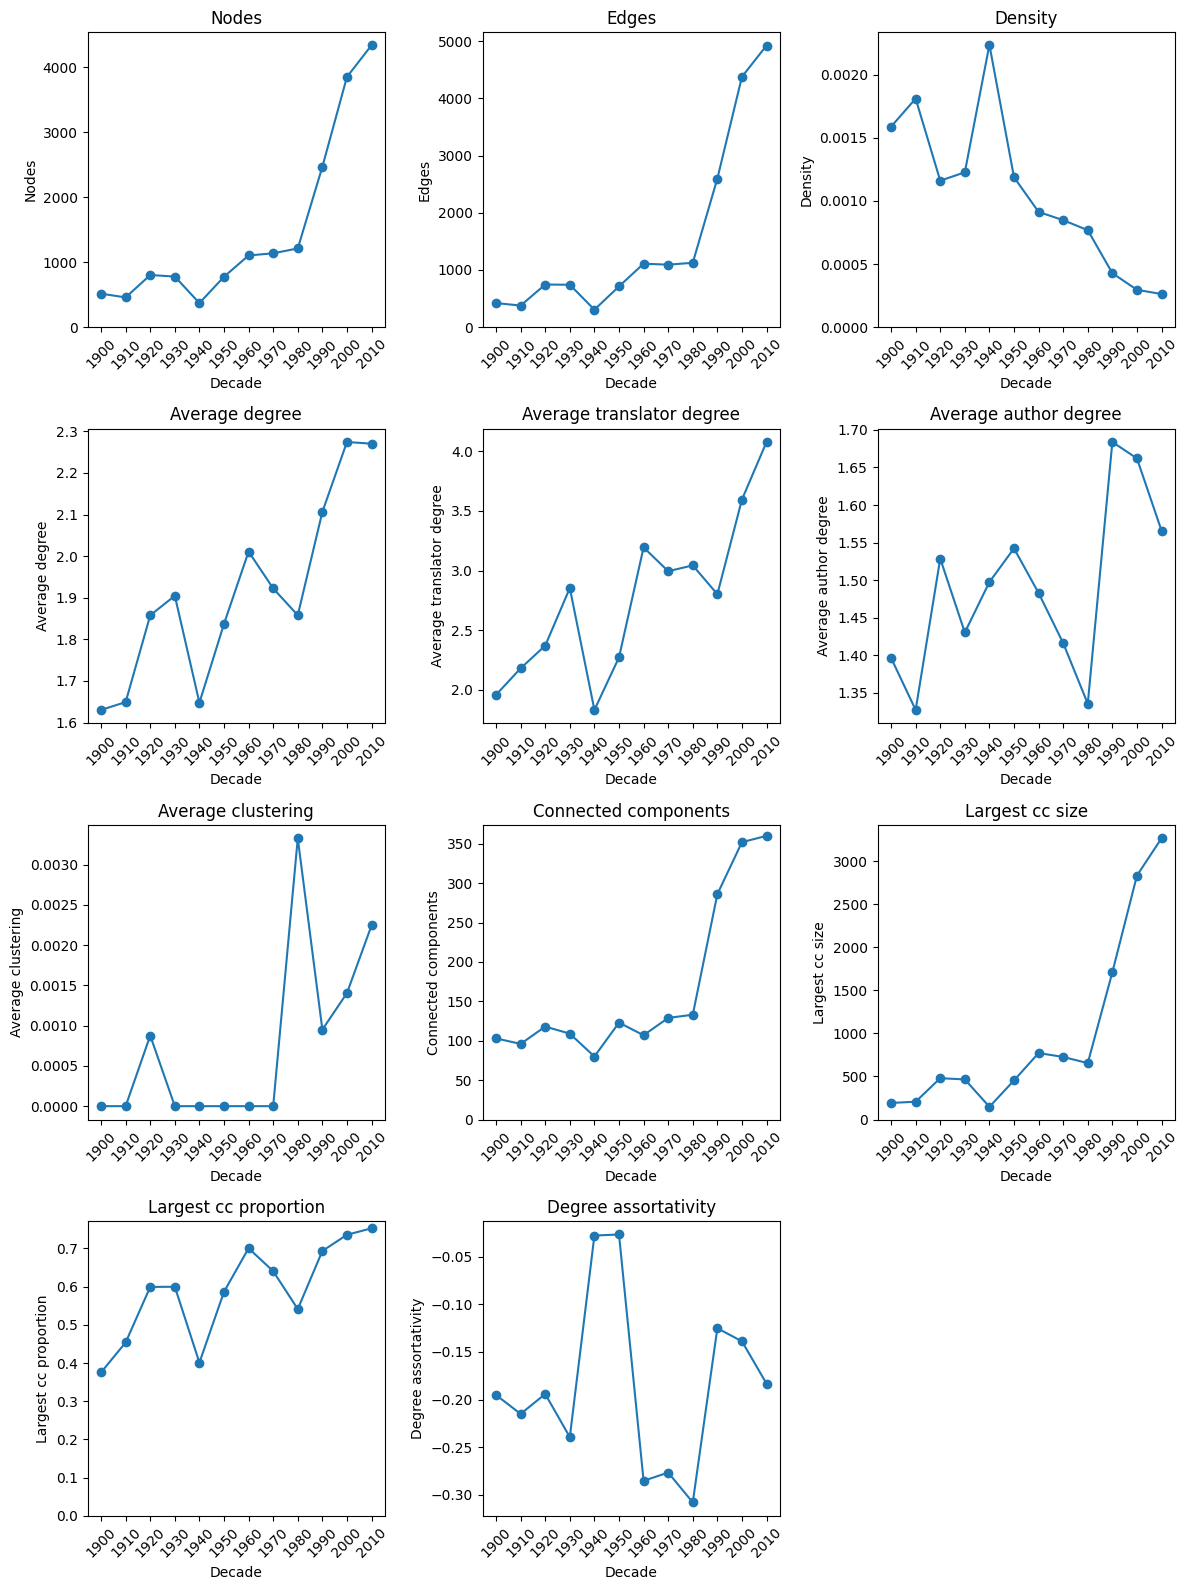

In [35]:
composite_plot(stats_list, timeranges_str)

In [9]:
def analyze_posthumousness(G):

    results = {"both_alive": 0,
                "author_dead": 0,
                "translator_dead": 0,
                "both_dead": 0,
                "unknown": 0}

    for edge in G.edges:
        dates = [work[1] for work in G.edges[edge]["works"]]
        transl_birth, transl_death = G.nodes[edge[0]]["date_of_birth"], G.nodes[edge[0]]["date_of_death"]
        author_birth, author_death = G.nodes[edge[1]]["date_of_birth"], G.nodes[edge[1]]["date_of_death"]

        if all([transl_birth, author_birth, transl_death, author_death]):
        
            for date in dates:
                if date <= transl_death and date <= author_death:
                    results["both_alive"] += 1
                elif date > transl_death and date > author_death:
                    results["both_dead"] += 1
                elif date > transl_death and date <= author_death:
                    results["translator_dead"] += 1
                elif date <= transl_death and date > author_death:
                    results["author_dead"] += 1
                else:
                    results["unknown"] += 1

    return results


In [10]:
posthumousness_data = [analyze_posthumousness(g) for g in graphs]

In [11]:
df_posthumous = pd.DataFrame.from_records(posthumousness_data, index=timeranges_str)
df_posthumous["time_period"] = df_posthumous.index

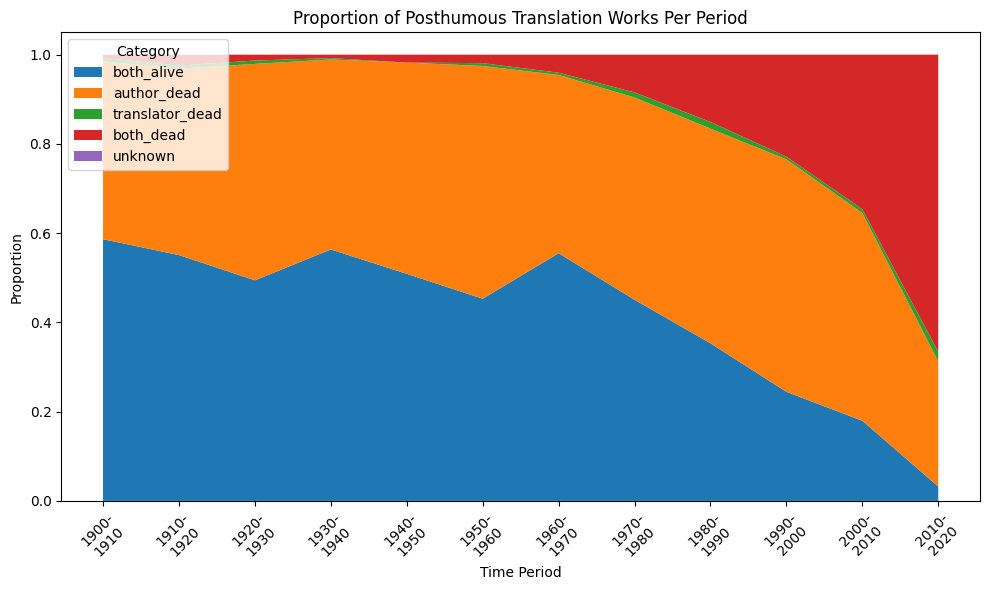

In [12]:
# Calculate proportions
df_proportions = df_posthumous.copy()
categories = ["both_alive", "author_dead", "translator_dead", "both_dead", "unknown"]
df_proportions[categories] = df_posthumous[categories].div(df_posthumous[categories].sum(axis=1), axis=0)

# Plot the stacked area chart
plt.figure(figsize=(10, 6))
plt.stackplot(
    df_posthumous["time_period"], 
    [df_proportions[category] for category in categories],
    labels=categories
)
plt.xlabel("Time Period")
plt.ylabel("Proportion")
plt.title("Proportion of Posthumous Translation Works Per Period")
plt.legend(title="Category", loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
def get_top_centrality(G, top_n, centrality_function, allowed_langs=None, only_authors=False, **kwargs):
    """
    Retrieves the top 10 nodes by a specified centrality measure along with their main role.

    Parameters:
    - G: NetworkX graph.
    - centrality_function: A function from NetworkX to compute a centrality measure 
      (e.g., nx.closeness_centrality, nx.degree_centrality).

    Returns:
    - A dictionary where keys are node labels and values are tuples (rank, main_role).
    """
    centrality = centrality_function(G, **kwargs)  # Compute the centrality measure
    sorted_nodes = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
    #return sorted_nodes

    rankings = {}
    while len(rankings) < top_n:
        for node, score in sorted_nodes:
            if len(rankings) >= top_n:  # Check before adding
                break
            role = G.nodes[node].get('main_role')
            lang = G.nodes[node].get('author_lang')
            if only_authors:
                if role == 'autor':
                    if allowed_langs and lang in allowed_langs:
                        rankings[node] = (len(rankings)+1, role, lang)
            elif allowed_langs and lang in allowed_langs:
                rankings[node] = (len(rankings)+1, role, lang)
        
    return rankings

In [59]:
color_dict = {
        "eng": "rgb(0, 221, 235)",
        "rus": "rgb(255, 111, 36)",
        "ger": "rgb(255, 130, 255)",
        "fre": "rgb(54, 224, 0)",
        "fin": "rgb(223, 170, 0)",
        "swe": "rgb(152, 204, 243)",
        "spa": "rgb(255, 163, 139)",
        "ita": "rgb(139, 216, 144)",
        "pol": "rgb(255, 91, 190)",
        "lav": "rgb(167, 165, 255)",
        "nor": "rgb(95, 80, 137)",
        "hun": "rgb(255, 172, 226)",
        "dan": "rgb(0, 211, 151)",
        "cze": "rgb(66, 117, 5)",
        "lit": "rgb(168, 50, 83)",
        "dut": "rgb(0, 109, 76)",
        "jpn": "rgb(255, 81, 114)",
        "rum": "rgb(125, 83, 0)",
        "ukr": "rgb(185, 171, 153)",
        "gre": "rgb(0, 184, 255)",
        "ice": "rgb(235, 190, 95)",
        "heb": "rgb(0, 86, 111)",
        "por": "rgb(0, 229, 255)",
        "bul": "rgb(161, 195, 0)",
        "bel": "rgb(216, 76, 32)",
        "lat": "rgb(255, 146, 0)",
        "geo": "rgb(0, 209, 69)",
        "slo": "rgb(203, 83, 192)",
        "udm": "rgb(0, 186, 205)",
        "tur": "rgb(178, 47, 33)",
        "arm": "rgb(230, 17, 3)",
        "chi": "rgb(27, 177, 255)",
        "ara": "rgb(118, 255, 118)",
        "cat": "rgb(156, 0, 206)",
        "slv": "rgb(0, 57, 243)",
        "kom": "rgb(255, 193, 148)",
        "hin": "rgb(101, 185, 207)",
        "yid": "rgb(202, 119, 197)",
        "san": "rgb(83, 255, 151)",
        "grc": "rgb(250, 253, 154)",
        "per": "rgb(119, 133, 81)",
        "srp": "rgb(162, 233, 187)",
        "fiu": "rgb(181, 4, 54)",
        "chm": "rgb(60, 0, 133)",
        "kor": "rgb(74, 190, 158)",
        "epo": "rgb(129, 0, 39)",
        "hrv": "rgb(95, 219, 196)",
        "aze": "rgb(15, 54, 131)",
        "mac": "rgb(167, 182, 202)",
        "tgk": "rgb(255, 70, 0)",
        "smi": "rgb(90, 127, 207)",
        "pro": "rgb(125, 38, 13)",
        "uzb": "rgb(206, 21, 0)",
        "peo": "rgb(54, 23, 198)",
        "kaz": "rgb(25, 144, 182)",
        "oss": "rgb(28, 125, 255)",
        "tat": "rgb(184, 0, 123)",
        "krl": "rgb(57, 189, 69)",
        "other": "rgb(150, 150, 150)",
        "und": 'rgb(150, 150, 150)'
    }

In [60]:
import plotly.graph_objects as go

def plot_interactive_slope_graph(ranking_data, periods, custom_title=None, savepath=None):
    """
    Creates an interactive slope graph of node rankings over time using names as unique identifiers.

    Parameters:
    - ranking_data: A list of dictionaries, where each dictionary contains
      the rankings for a specific period (e.g., {"Name": (1, "autor", "eng"), ...}).
    - periods: A list of time period labels corresponding to the ranking data.
    - custom_title: An optional custom title for the plot.
    - savepath: If provided, saves the plot as an HTML file at this path.
    """

    # Create a figure
    fig = go.Figure()

    # Iterate through all unique nodes
    for node in set(n for period in ranking_data for n in period.keys()):
        ranks = []
        roles = []
        languages = []
        for period in ranking_data:
            data = period.get(node, None)  # Get (rank, role, language) or None
            if data:
                ranks.append(data[0])
                roles.append(data[1])
                language = data[2]
                languages.append(language)
            else:
                ranks.append(None)
                roles.append(None)
                languages.append(None)

        # Plot line for the node if it has ranks in multiple periods
        if any(rank is not None for rank in ranks):
            # Pick the first non-None language for coloring
            node_language = next((lang for lang in languages if lang is not None), "eng")
            color = color_dict.get(node_language, "rgb(0,0,0)")

            fig.add_trace(go.Scatter(
                x=periods,
                y=ranks,
                mode='lines+markers+text',
                name=node,
                textposition="top center",
                line=dict(color=color, width=1),
                marker=dict(size=10, color=color),
                hoverinfo="text",
                hovertext=[
                    f"Name: {node}<br>Rank: {rank}<br>Role: {role}<br>Language: {lang}" 
                    if rank is not None else ""
                    for rank, role, lang in zip(ranks, roles, languages)
                ],
                connectgaps=False  # Prevents connecting gaps in the solid line
            ))

            # Add dotted line for non-consecutive points
            valid_points = [(p, r) for p, r in zip(periods, ranks) if r is not None]
            if len(valid_points) > 1:
                dotted_x, dotted_y = zip(*valid_points)
                fig.add_trace(go.Scatter(
                    x=dotted_x,
                    y=dotted_y,
                    mode='lines',
                    name=node,
                    line=dict(color=color, width=0.5, dash="dot"),
                    showlegend=False  # No need to duplicate legend entries
                ))

    # Reverse the y-axis for rankings (1 at the top)
    fig.update_yaxes(autorange="reversed", title_text="Rank")

    # Update layout with xtick labels matching periods
    fig.update_layout(
        title=custom_title or "Interactive Node Rankings Over Time",
        xaxis=dict(
            tickmode='array',
            tickvals=periods,
            ticktext=periods,
            tickangle=45
        ),
        yaxis=dict(autorange="reversed", title_text="Rank"),
        hovermode="closest",
        legend_title="Names",
        height=700,
        width=1500,
        showlegend=False
    )

    if savepath:
        fig.write_html(savepath)

    fig.show()

In [66]:
closeness_rankings = [get_top_centrality(g, 30, nx.closeness_centrality, only_authors=True, allowed_langs=color_dict.keys()) for g in graphs]
plot_interactive_slope_graph(closeness_rankings, timeranges_str, "Most central nodes over time (closeness centrality)", savepath="plots/closeness.html")

In [ ]:
graphs[7].edges()

In [126]:
betweenness_rankings = [get_top_centrality(g, 20, nx.betweenness_centrality, weight="weight") for g in graphs]
plot_interactive_slope_graph(betweenness_rankings, timeranges_str, "Most central nodes over time (betweenness centrality)", savepath="plots/betweenness.html")

In [163]:
degree_rankings = [get_top_centrality(g, 30, nx.degree_centrality) for g in graphs]
plot_interactive_slope_graph(degree_rankings, timeranges_str, "Most central nodes over time (degree centrality)", savepath="plots/degree.html")

In [119]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter

def plot_degree_distribution_diachronic(networks, time_ranges):
    """
    Plots the degree distribution for a list of diachronic networks.

    Parameters:
    - networks: List of NetworkX graphs for each time period.
    - time_ranges: List of time range labels corresponding to the networks.
    """
    plt.figure(figsize=(10, 6))

    for i, G in enumerate(networks):
        # Get degree counts
        degrees = [d for _, d in G.degree()]
        degree_counts = Counter(degrees)

        # Normalize to get probability
        degrees, counts = zip(*sorted(degree_counts.items()))
        probabilities = [c / sum(degree_counts.values()) for c in counts]

        # Plot the degree distribution
        plt.plot(degrees, probabilities, marker='o', linestyle='-', label=f"{time_ranges[i]}")

    # Log-log scale for better visualization of patterns
    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Degree (k)")
    plt.ylabel("P(k) - Probability")
    plt.title("Degree Distribution Over Time")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

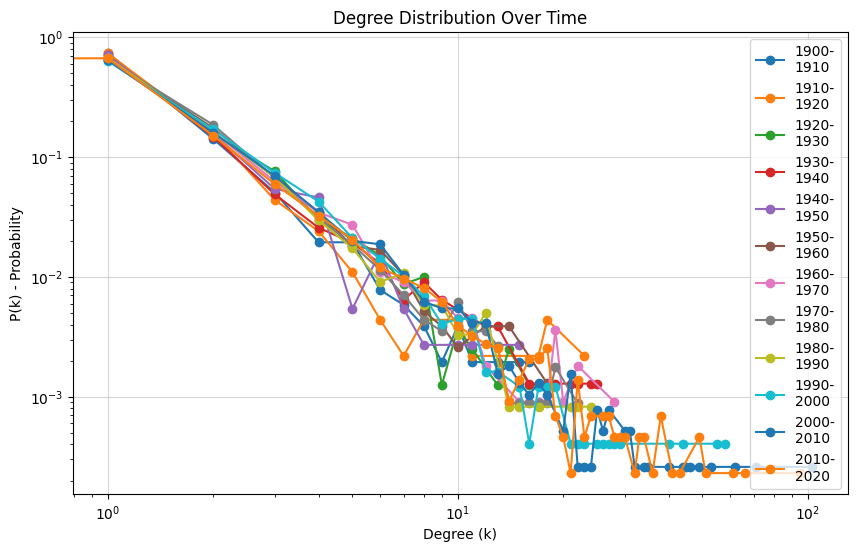

In [120]:
plot_degree_distribution_diachronic(graphs, timeranges_str)

### Clustering

In [136]:
test_communities = nx.community.louvain_communities(graphs[9], seed=42)
community_subgraphs = [nx.subgraph(graphs[9], community) for community in test_communities]

In [137]:
langs = {}
for i, graph in enumerate(community_subgraphs):
    edges = graph.edges(data=True)
    langs[i] = {}
    for e in edges:
        languages = e[2]["languages"]
        for l in languages:
            if l in langs[i].keys():
                langs[i][l] += 1
            else:
                langs[i][l] = 1


In [156]:
import math

def calculate_language_metrics(community_language_data):
    """
    Calculates language centralization metrics for communities.

    Parameters:
    - community_language_data: List of tuples, where each tuple contains:
        (community_id, {language: count})

    Returns:
    - A dictionary with the calculated metrics for each community:
        {
            community_id: {
                'dominant_language': str,
                'dominant_proportion': float,
                'entropy': float,
                'language_counts': dict
            }
        }
    """
    metrics = {}

    for community_id, language_counts in community_language_data.items():
        total_edges = sum(language_counts.values())

        # Proportion of the dominant language
        dominant_language, dominant_count = max(language_counts.items(), key=lambda x: x[1])
        dominant_proportion = dominant_count / total_edges

        # Language entropy
        entropy = -sum(
            (count / total_edges) * math.log(count / total_edges)
            for count in language_counts.values()
            if count > 0
        )

        # Store results
        metrics[community_id] = {
            'total_edges': total_edges,
            'dominant_language': dominant_language,
            'dominant_proportion': dominant_proportion,
            'entropy': entropy,
            'language_counts': language_counts,
        }

    return metrics

In [158]:
metrics = calculate_language_metrics(langs)

In [163]:
metrics = sorted(metrics.items(), key=lambda x: x[1]["total_edges"], reverse=True)

In [176]:
n_edges = [x[1]["total_edges"] for x in metrics]
dominant_proportions = [x[1]["dominant_proportion"] for x in metrics]
dominant_color = [color_dict[x[1]["dominant_language"]] for x in metrics]

KeyError: 'und'

In [177]:
color_dict

{'eng': 'rgb(0, 221, 235)',
 'rus': 'rgb(255, 111, 36)',
 'ger': 'rgb(255, 130, 255)',
 'fre': 'rgb(54, 224, 0)',
 'fin': 'rgb(223, 170, 0)',
 'swe': 'rgb(152, 204, 243)',
 'spa': 'rgb(255, 163, 139)',
 'ita': 'rgb(139, 216, 144)',
 'pol': 'rgb(255, 91, 190)',
 'lav': 'rgb(167, 165, 255)',
 'nor': 'rgb(95, 80, 137)',
 'hun': 'rgb(255, 172, 226)',
 'dan': 'rgb(0, 211, 151)',
 'cze': 'rgb(66, 117, 5)',
 'lit': 'rgb(168, 50, 83)',
 'dut': 'rgb(0, 109, 76)',
 'jpn': 'rgb(255, 81, 114)',
 'rum': 'rgb(125, 83, 0)',
 'ukr': 'rgb(185, 171, 153)',
 'gre': 'rgb(0, 184, 255)',
 'ice': 'rgb(235, 190, 95)',
 'heb': 'rgb(0, 86, 111)',
 'por': 'rgb(0, 229, 255)',
 'bul': 'rgb(161, 195, 0)',
 'bel': 'rgb(216, 76, 32)',
 'lat': 'rgb(255, 146, 0)',
 'geo': 'rgb(0, 209, 69)',
 'slo': 'rgb(203, 83, 192)',
 'udm': 'rgb(0, 186, 205)',
 'tur': 'rgb(178, 47, 33)',
 'arm': 'rgb(230, 17, 3)',
 'chi': 'rgb(27, 177, 255)',
 'ara': 'rgb(118, 255, 118)',
 'cat': 'rgb(156, 0, 206)',
 'slv': 'rgb(0, 57, 243)',
 'kom'

In [175]:
metrics[1]

(144,
 {'total_edges': 191,
  'dominant_language': 'eng',
  'dominant_proportion': 0.9738219895287958,
  'entropy': 0.12119452295330035,
  'language_counts': {'eng': 186, 'fre': 5}})

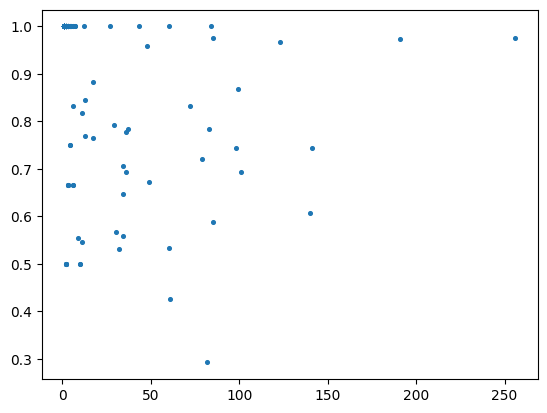

In [173]:
plt.scatter(n_edges, dominant_proportions, s=7, c)
plt.show()

In [61]:
df.loc[37256, "contributor"]

"Paves, Taimi (1962-) [koostaja]; Paves, Taimi (1962-) [tõlkija]; Koll, Kersti (1961-) [koostaja]; Ehin, Andres (1940-2011) [tõlkija]; Fujitomi, Yasuo (1928-) [tõlkija]; Natsuishi, Ban'ya (1955-) [tõlkija]; Blythe, R. H [tõlkija]; Burleigh, David (1950-) [tõlkija]; Carter, Stewen [tõlkija]; Cobb, David [tõlkija]; Gurga, Lee [tõlkija]; Kacian, Jim [tõlkija]; Kato, Koko [tõlkija]; Kurose, Hiroko [tõlkija]; Lehtpere, Ilmar (1950-) [tõlkija]; Meltsas, Hetti (1979-) [tõlkija]; Miyashita, Emiko [tõlkija]; Nakaoka, Naomi [tõlkija]; Ueda, Makoto (1931-) [tõlkija]; Heamägi, Inga (1961-) [kujundaja]"

### Statistics

In [102]:
df = erb_main.query('is_fiction == True and creator.notna() and contributor.str.contains("tõlkija") and language == "est" and language_original.notna()'
    )

In [107]:
print(len(df))
print(df.publication_date_cleaned.min())

28239
1839


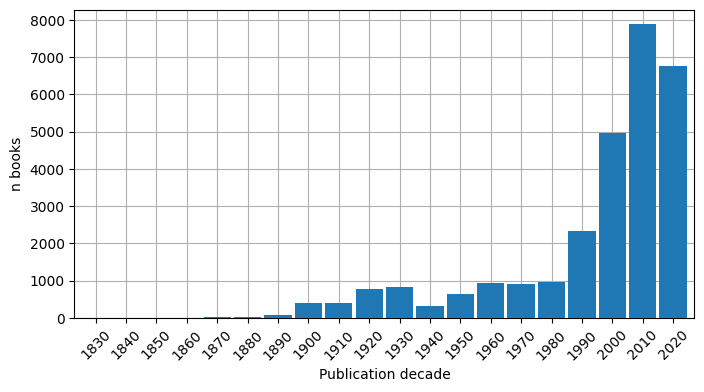

In [104]:
fig, ax = plt.subplots(figsize=(8,4))
df.publication_decade.value_counts().sort_index().plot.bar(ax=ax, width=0.9, zorder=3)
ax.grid(zorder=0)
plt.xticks(rotation=45, ha="center")
plt.xlabel("Publication decade")
plt.ylabel("n books")

plt.savefig("plots/n_books.png", bbox_inches="tight", dpi=300)

plt.show()

In [51]:
df.loc[df.contributor.str.contains('Ehin, Andres (1940-2011)', regex=False), ["creator", "contributor", "language_original", "language", "publication_date"]]

,creator,contributor,language_original,language,publication_date
25,"Shields, Carol (1935-2003) [autor]","Ehin, Andres (1940-2011) [tõlkija]; Seppel, Ly...",eng,est,1999
10178,"Navoii, Ališer (1441-1501) [autor]","Konrad, N [eessõna autor]; Liiva, Silvi (1941-...",uzb,est,1977
14327,"Ragan, James (1944-) [autor]","Ehin, Andres (1940-2011) [tõlkija]; Ürt, Juliu...",eng,est,c2005
16298,"Dahl, Roald (1916-1990) [autor]","Aareleid, Epp (1981-) [tõlkija]; Ehin, Andres ...",eng,est,c2010
29481,"Nagibin, Juri (1920-1994) [autor]","Liidja, Marja (1936-) [tõlkija]; Tammsaar, Jaa...",rus,est,1981
37256,"Ehin, Andres (1940-2011) [autor]","Paves, Taimi (1962-) [koostaja]; Paves, Taimi ...",jpn,est,2013
50507,<NA>,"Skujenieks, Knuts (1936-2022) [koostaja]; Godi...",lav,est,1997
58955,<NA>,"Seppel, Ly (1943-) [tõlkija]; Ehin, Andres (19...",fin,est,1997
62371,"Sobolev, Leonid (1898-1971) [autor]","Lepik, Peet (1935-) [tõlkija]; Ehin, Andres (1...",rus,est,1976
69705,<NA>,"Seppel, Ly (1943-) [koostaja]; Ehin, Andres (1...",tur,est,1997


In [14]:
def plot_node_rankings_with_roles(ranking_data, periods):
    """
    Plots a slope graph of node rankings over time, colored by roles.

    Parameters:
    - ranking_data: A list of dictionaries, where each dictionary contains
      the rankings for a specific period (e.g., {"A": (1, "autor"), ...}).
    - periods: A list of time period labels corresponding to the ranking data.
    """
    # Create a color palette for roles
    role_colors = {"autor": "blue", "tõlkija": "green"}

    plt.figure(figsize=(10, 6))

    for node in set(n for period in ranking_data for n in period.keys()):
        ranks = []
        roles = []
        for period in ranking_data:
            data = period.get(node, None)  # Get rank and role or None
            if data:
                ranks.append(data[0])  # Append the rank
                roles.append(data[1])  # Append the role
            else:
                ranks.append(None)  # No rank for this period
                roles.append(None)  # No role for this period

        # Plot line for the node if it has ranks in multiple periods
        if any(rank is not None for rank in ranks):
            # Get the role from the first non-None instance
            role = next(role for role in roles if role is not None)
            plt.plot(
                periods, 
                ranks, 
                marker="o", 
                label=node, 
                color=role_colors[role]
            )

    # Reverse the y-axis for rankings (1 at the top)
    plt.gca().invert_yaxis()

    plt.xticks(rotation=45)
    plt.xlabel("Time Period")
    plt.ylabel("Rank")
    plt.title("Node Rankings Over Time by Role")
    plt.grid(alpha=0.5)

    # Create a legend for roles
    for role, color in role_colors.items():
        plt.plot([], [], label=role.capitalize(), color=color, marker="o", linestyle="")
    plt.legend(title="Roles", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

C:\Users\krister.kruusmaa\AppData\Local\Temp\ipykernel_9336\3619465862.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


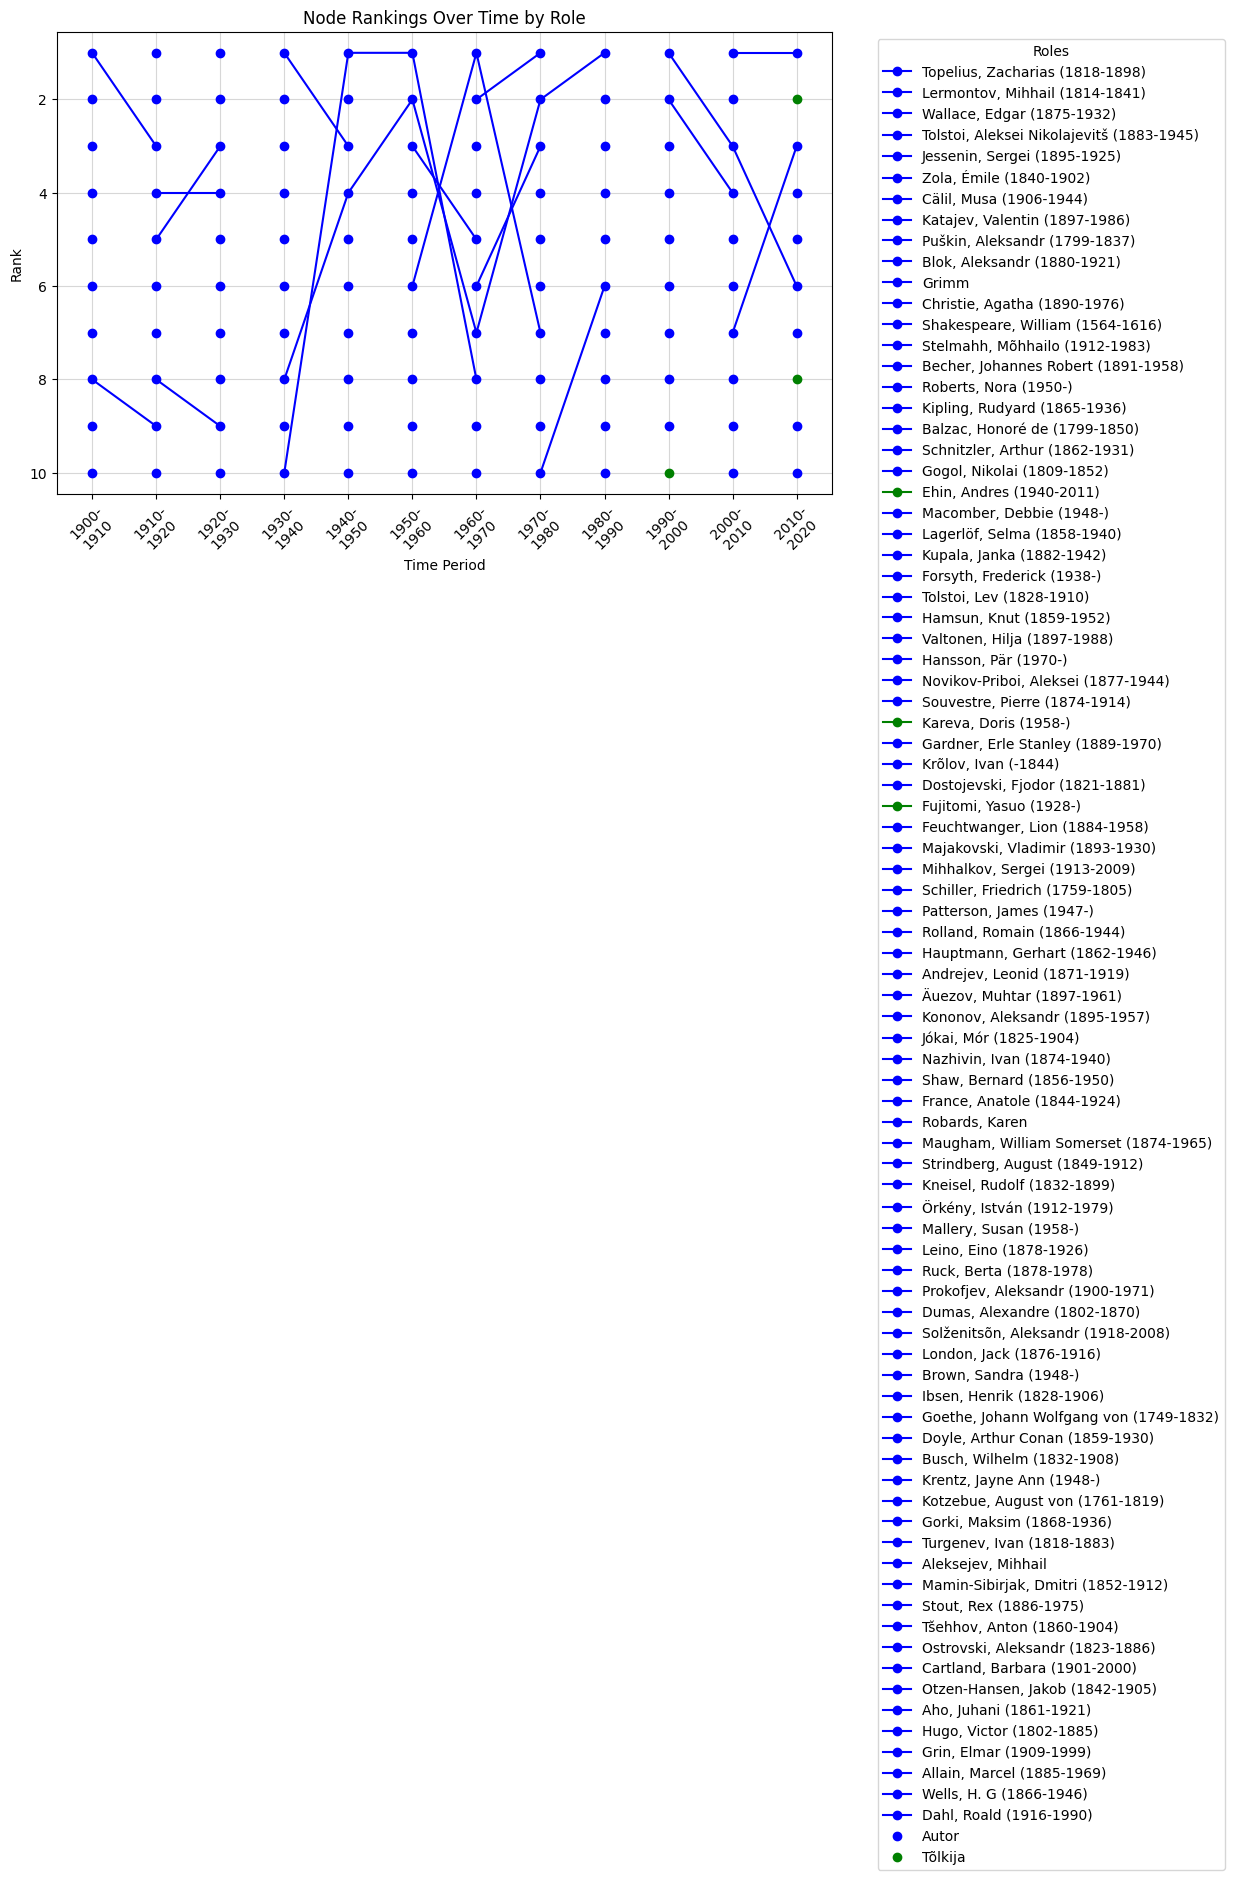

In [15]:
closeness_rankings = [get_top10_centrality(g, nx.closeness_centrality) for g in graphs]
plot_node_rankings_with_roles(closeness_rankings, timeranges_str)

C:\Users\krister.kruusmaa\AppData\Local\Temp\ipykernel_9336\3619465862.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


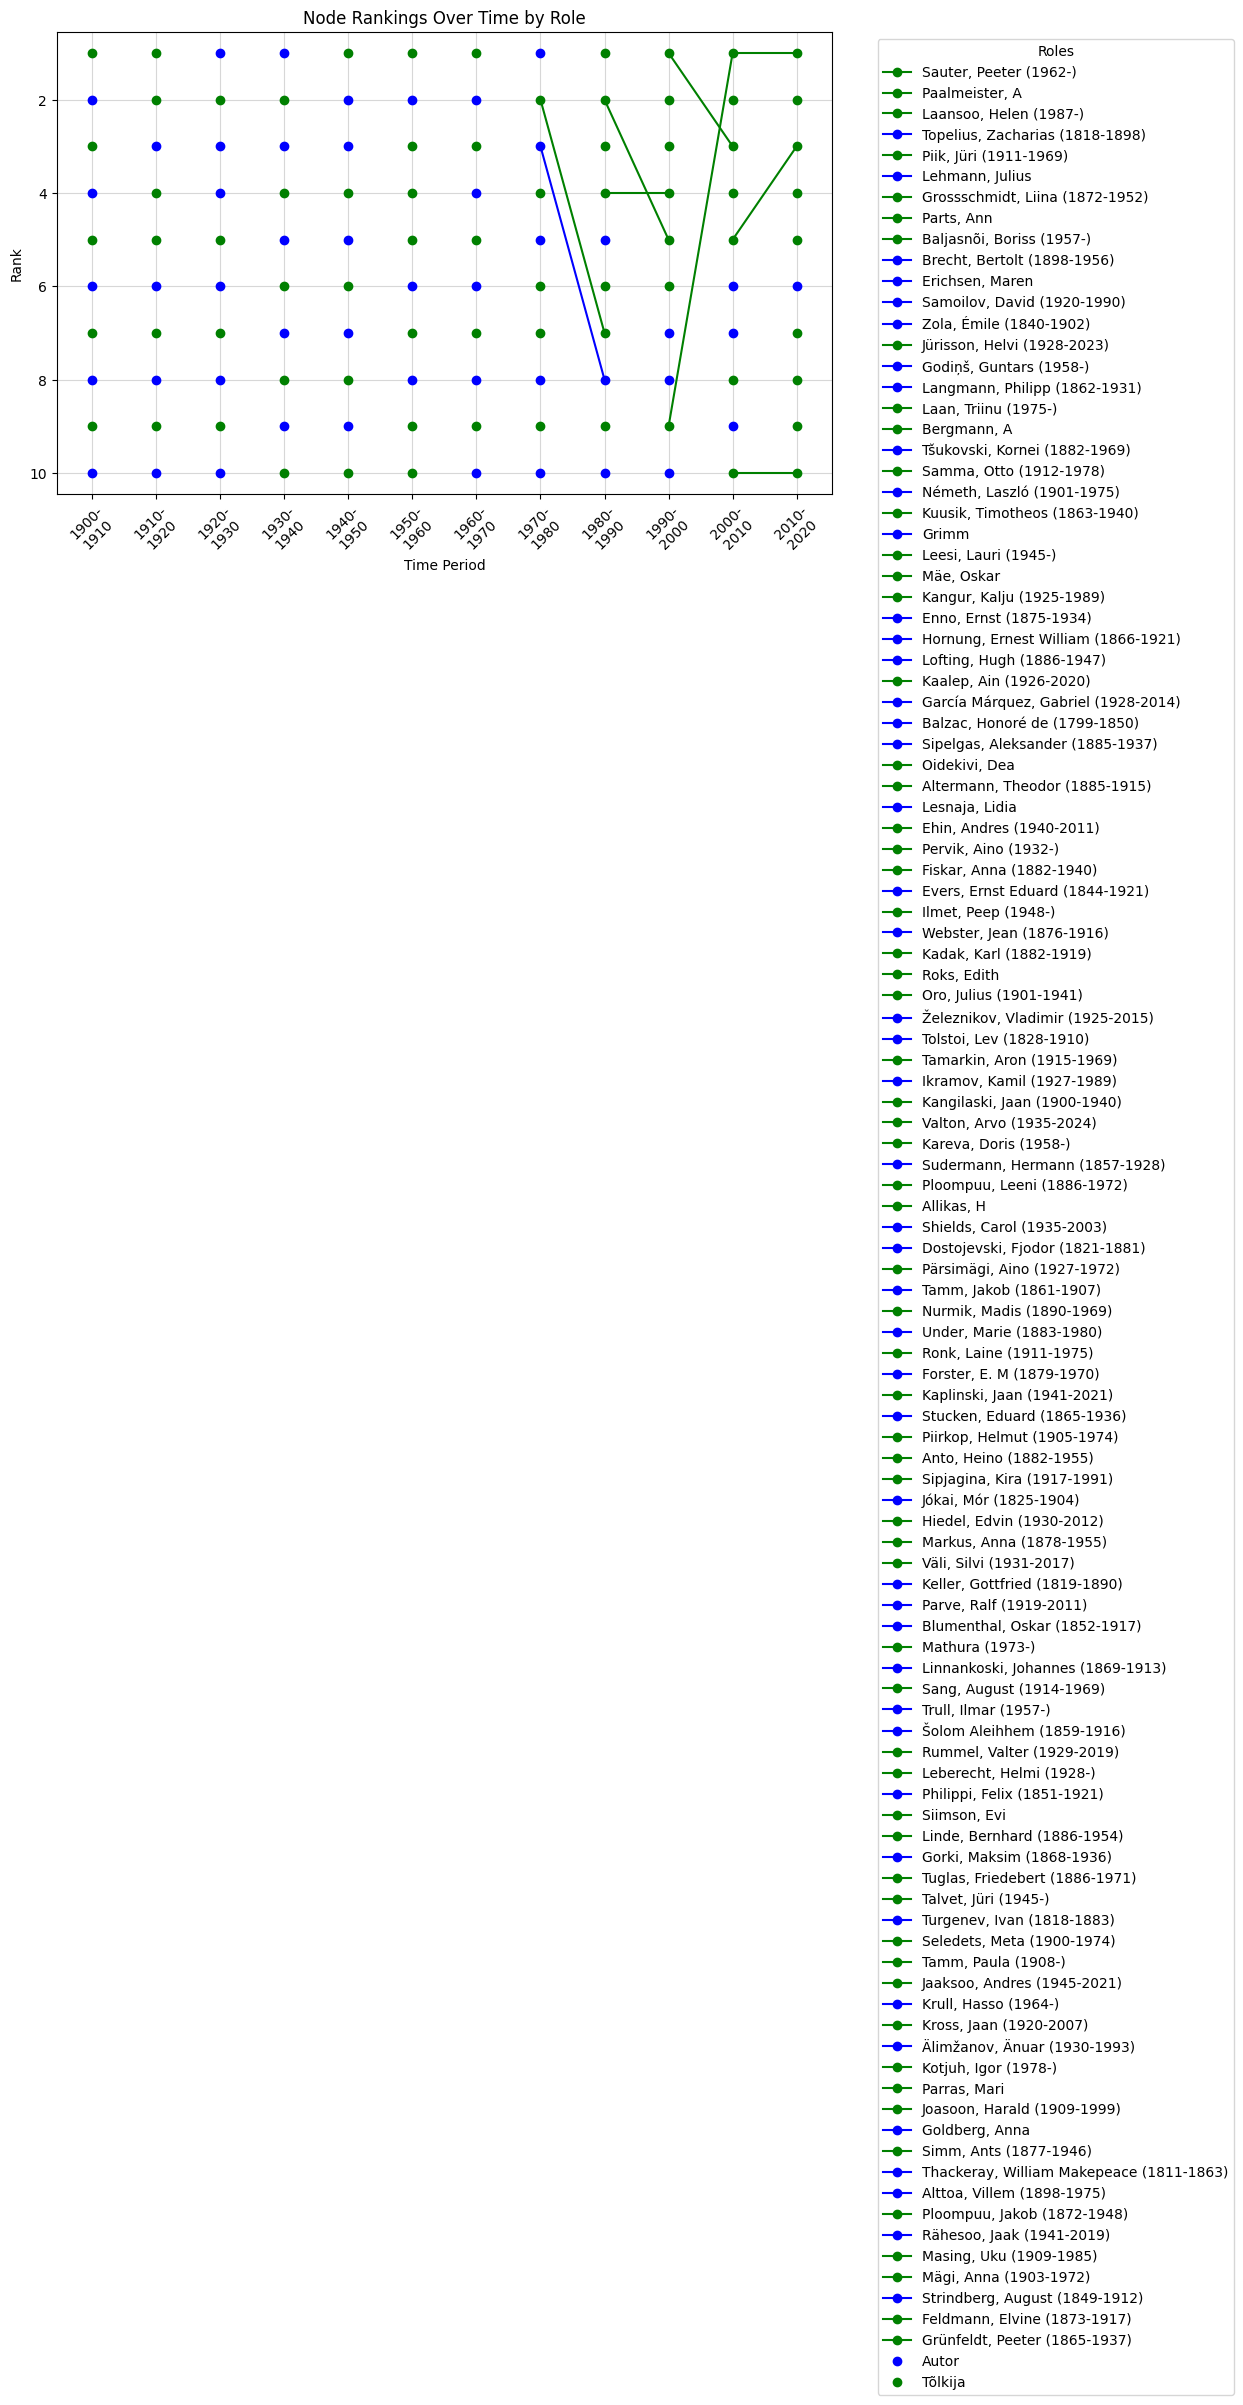

In [16]:
betweenness_rankings = [get_top10_centrality(g, nx.betweenness_centrality) for g in graphs]
plot_node_rankings_with_roles(betweenness_rankings, timeranges_str)

C:\Users\krister.kruusmaa\AppData\Local\Temp\ipykernel_9336\3619465862.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


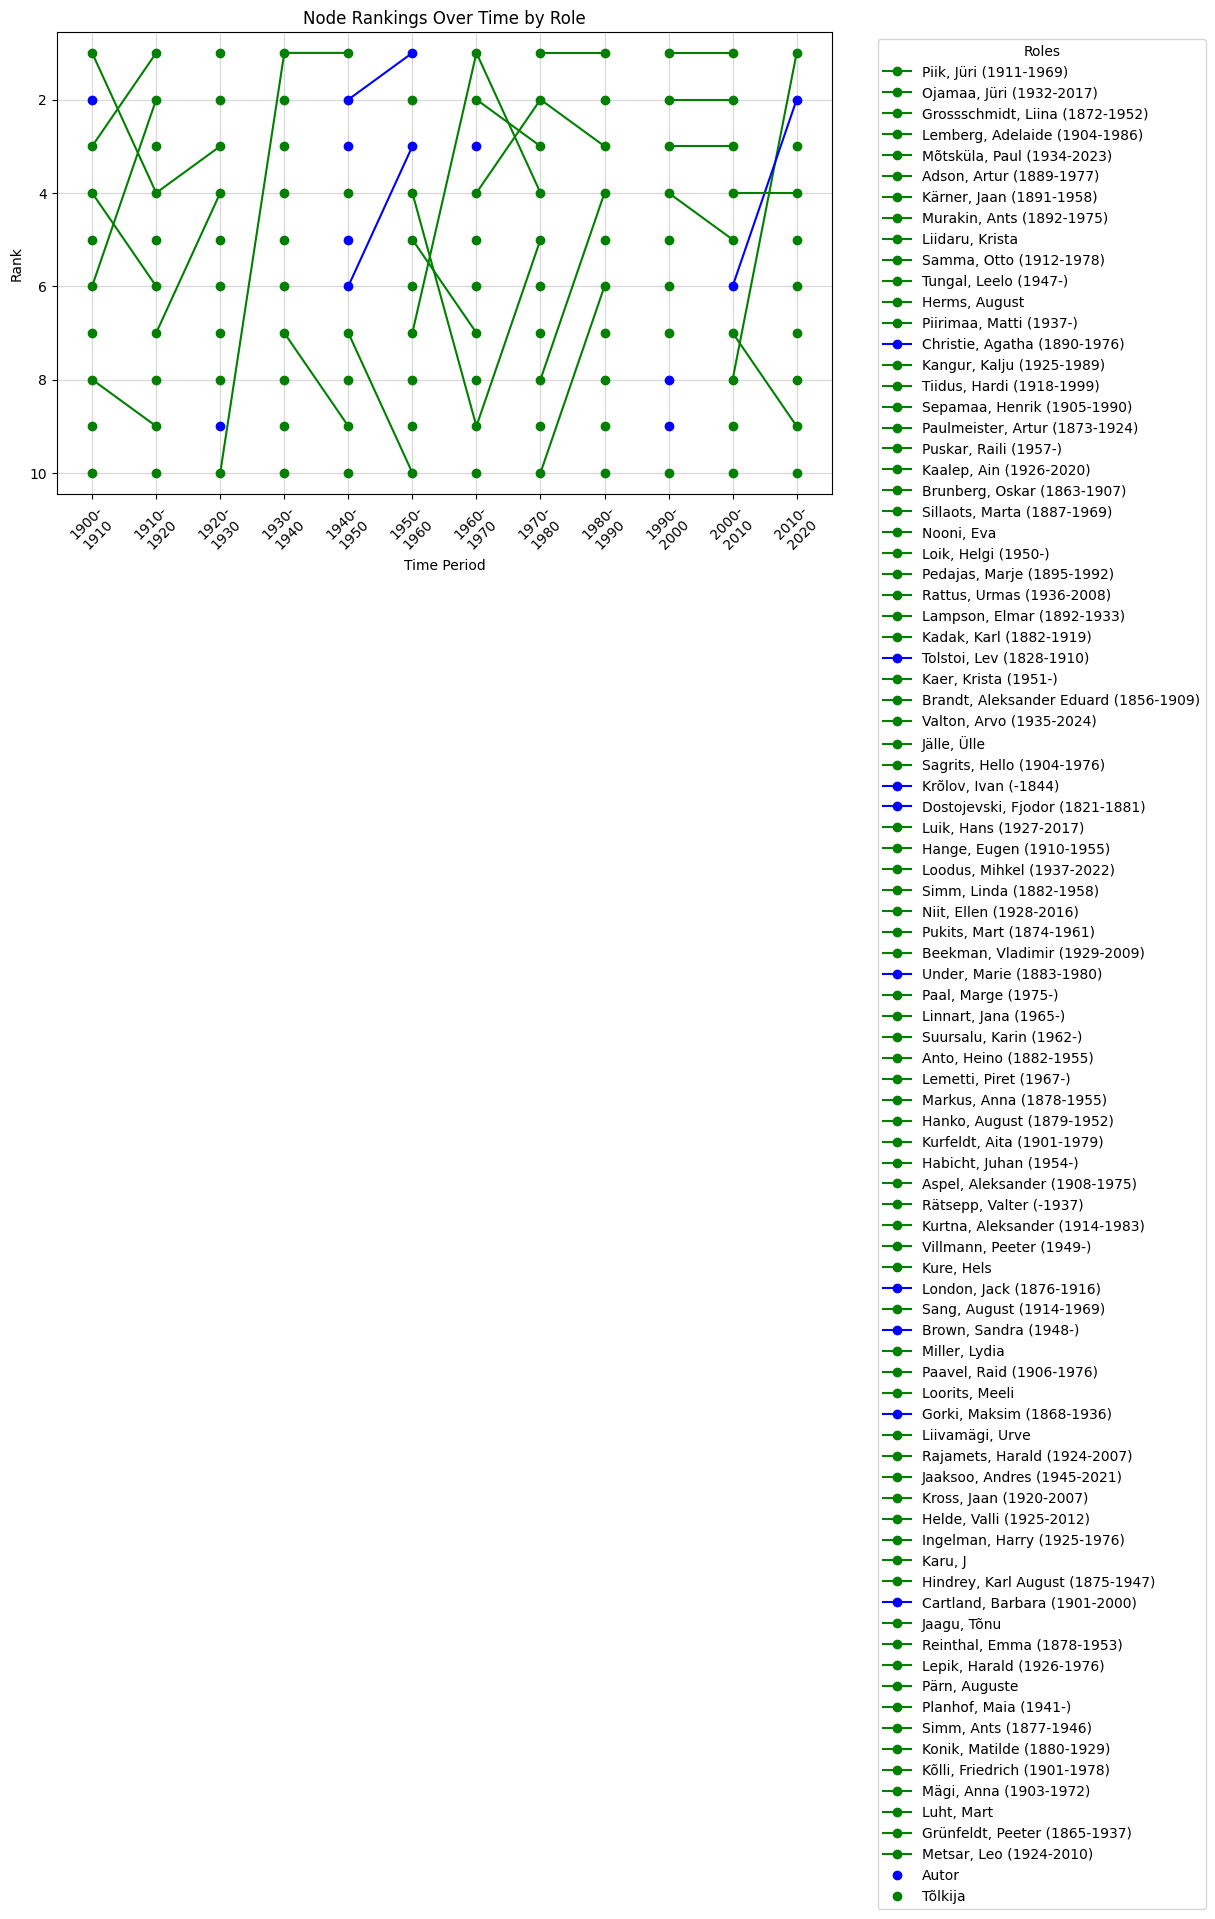

In [17]:
degree_rankings = [get_top10_centrality(g, nx.degree_centrality) for g in graphs]
plot_node_rankings_with_roles(degree_rankings, timeranges_str)

In [32]:
plot_interactive_slope_graph(closeness_rankings, timeranges_str)

In [1]:
from create_graph import tidy_translators
import pandas as pd
import json
import re
import networkx as nx
import itertools
from collections import Counter
pd.set_option('display.max_columns', None)

In [2]:
with open("../data/roles.json", "r", encoding="utf8") as f:
    roles = json.load(f)
    roles_compact = list(set(roles.values()))

with open("../data/genres.json", "r", encoding="utf8") as f:
    genres = json.load(f)
    fiction = genres["fiction"]

In [3]:
erb_main = pd.read_parquet("../data/raw/erb_all_books.parquet")

In [4]:
df = erb_main.query('is_fiction == True and language == "est" and language_original.notna()')

In [5]:
df

,id,date_entered,isbn,creator,contributor,publisher,title,title_remainder,title_part_nr,title_part_nr_cleaned,title_varform,title_original,title_freeform,publication_date_control,publication_date,publication_date_cleaned,publication_decade,publication_place_control,publication_place,added_intermediate_political_jurisdiction,added_city,place_of_manufacture,manufacturer,corporate_unit,series_statement,edition_statement,edition_n,original_distribution_year,original_distribution_place,original_distribution_publisher,language,language_additional,language_original,language_note,is_fiction,is_posthumous,udc,topic_keyword,genre_keyword,geographic_keyword,chronological_keyword,corporate_keyword,person_keyword,page_count,illustrated,physical_size,print_run,price,typeface,bibliography_register,copyright_status,digitized,digitized_year,access_uri
23,b15702388,2001-11-23,9985823230,"Tralow, Johannes (1882-1968) [autor]","Malinen, Maila [tõlkija]; Sildre, Tiina (1959-...",Ajaraamat,Roxelane,romaan,<NA>,<NA>,,Roxelane,<NA>,2001,2001,2001,2000,er,Tallinn,<NA>,<NA>,Tallinn,Ühiselu,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,est,est,ger,<NA>,True,True,821.112.2-311.6,saksa [EMS022171],ilukirjandus (vormimärksõna) [EMS002472]; ajal...,<NA>,<NA>,<NA>,<NA>,415,False,22,<NA>,<NA>,<NA>,<NA>,<NA>,False,<NA>,<NA>
25,b12919688,1999-10-12,9985303067,"Shields, Carol (1935-2003) [autor]","Ehin, Andres (1940-2011) [tõlkija]; Seppel, Ly...",Varrak,Kivist päevaraamatud,romaan,<NA>,<NA>,,The stone diaries,The stone diaries; Auhind: Pulitzeri romaanipr...,1999,1999,1999,1990,er,Tallinn,<NA>,<NA>,Tallinn,Ühiselu,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,est,est,eng,<NA>,True,False,821.111,inglise [EMS022170],ilukirjandus (vormimärksõna) [EMS002472]; roma...,Kanada (riik) [EMS131809],<NA>,<NA>,<NA>,351,False,21,<NA>,<NA>,<NA>,<NA>,<NA>,False,<NA>,<NA>
27,b13564158,2000-02-22,<NA>,"Németh, Laszló (1901-1975) [autor]","Beladi, Miklós [järelsõna autor]; Hiedel, Edvi...",Eesti Raamat,Ängistus,romaan,<NA>,<NA>,,Iszony,<NA>,1969,1969,1969,1960,er,Tallinn,<NA>,<NA>,Tartu,H. Heidemanni nim. trükikoda,<NA>,XX sajandi raamat,<NA>,<NA>,<NA>,<NA>,<NA>,est,est,hun,<NA>,True,False,821.511.141-31,ungari [EMS175029],ilukirjandus (vormimärksõna) [EMS002472]; roma...,<NA>,<NA>,<NA>,<NA>,384,False,21,<NA>,<NA>,<NA>,<NA>,<NA>,False,<NA>,<NA>
28,b1292281x,1999-10-05,9789916080634,"Älimžanov, Änuar (1930-1993) [autor]","Parts, Ann [tõlkija]; Mašrapov, B [illustreerija]",Eesti Raamat,Kuller,romaan : keskmisele ja vanemale koolieale,<NA>,<NA>,<NA>,<NA>,<NA>,1980,1980,1980,1980,er,Tallinn,<NA>,<NA>,<NA>,<NA>,<NA>,15,<NA>,<NA>,<NA>,<NA>,<NA>,est,est,rus,<NA>,True,False,821.512.122-93-31,kasahhi [EMS151881],noorsookirjandus []; romaanid (vormimärksõna) ...,<NA>,<NA>,<NA>,<NA>,318,True,17,<NA>,<NA>,<NA>,<NA>,<NA>,True,2022,https://www.digar.ee/id/nlib-digar:657471
29,b15683746,2001-11-12,<NA>,"Goldberg, Anna [autor]","Lesnaja, Lidia [autor]; Seledets, Meta (1900-1...",Pedagoogiline Kirjandus,Helesinine vaip,muinasjutt,<NA>,<NA>,,Голубой ковер,<NA>,1941,1941,1941,1940,er,Tallinn,<NA>,<NA>,Tallinn,Punane Täht,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,est,est,rus,<NA>,True,False,821-93,tadžiki [EMS148300],lastekirjandus (vormimärksõna) [EMS009177]; mu...,<NA>,<NA>,<NA>,<NA>,30,True,21,3150,<NA>,<NA>,<NA>,<NA>,False,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222834,b14716161,2001-02-21,<NA>,"Wasilewska, Wanda (1905-1964) [autor]","Linask, Väino (1912-1981) [tõlkija]; Lepp, Esk...",Ilukirjandus ja Kunst,Lihtsalt armastus,jutustus,<NA>,<NA>,<NA>,<NA>,<NA>,1947,1947,1947,1940,er,Tallinn,<NA>,<NA>,Tallinn,Ühiselu,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,est,est,rus,<NA>,True,False,821.162.1-31,poola [EMS174989]; ilukirjandus [EMS002472],jutustused (vormimärksõna) [EMS009148],<NA>,<NA>,<NA>,<NA>,154,False,20,<NA>,<NA>,<NA>,<NA>,<NA>,False,<NA>

In [6]:
def extract_person_info(person_str, role=True):
    # Remove any titles enclosed in quotes
    person_str = re.sub(r': ".*?"', '', person_str)

    # Helper function to process individual dates
    def process_date(date_str):
        if not date_str:
            return None, False  # Return None and BC indicator as False
        date_str = date_str.strip()
        is_bc = False

        # Remove 'u. ' prefix indicating uncertainty
        date_str = re.sub(r'^u\. ?', '', date_str)

        # Check for 'e. Kr' (BC dates) and 'p. Kr' (AD dates)
        bc_match = re.search(r'e\. ?Kr\.?', date_str, re.IGNORECASE)
        ad_match = re.search(r'p\. ?Kr\.?', date_str, re.IGNORECASE)
        if bc_match:
            is_bc = True
        elif ad_match:
            is_bc = False  # Explicitly marked as AD

        # Remove 'e. Kr' or 'p. Kr' suffixes
        date_str = re.sub(r'(e\. ?Kr\.?|p\. ?Kr\.?)', '', date_str, flags=re.IGNORECASE).strip()

        # Convert date string to integer
        try:
            date_int = int(date_str)
            return date_int, is_bc
        except ValueError:
            return None, False  # Return None if the date is not a valid integer

    # Regular expression pattern to match the entire string
    # Matches: Name (birth_date - death_date) [role]
    pattern = r'^(.+?)\s*\((.*?)\)\s*(?:\[(.+?)\])?$'

    match = re.match(pattern, person_str)
    if match:
        name, date_range, role_str = match.groups()
        name = name.strip()
        role_str = role_str.strip().lower() if role_str and role else None

        # Split the date range into birth and death dates
        birth_date_str, _, death_date_str = date_range.partition('-')

        # Process birth and death dates
        birth_date, birth_is_bc = process_date(birth_date_str)
        death_date, death_is_bc = process_date(death_date_str)

        # If the death date is BC and the birth date is not explicitly AD, assume birth date is BC
        if death_is_bc and not birth_is_bc and birth_date is not None:
            birth_is_bc = True
            birth_date = -birth_date
        elif birth_is_bc and birth_date is not None:
            birth_date = -birth_date

        # If the death date is BC, make it negative
        if death_is_bc and death_date is not None:
            death_date = -death_date

        if role:
            return (name, birth_date, death_date, role_str)
        else:
            return (name, birth_date, death_date)

    # Handle cases with only the name and optional role
    # Matches: Name [role] or Name
    pattern_name_role = r'^(.+?)\s*(?:\[(.+?)\])?$'
    match = re.match(pattern_name_role, person_str)
    if match:
        name, role_str = match.groups()
        name = name.strip()
        role_str = role_str.strip().lower() if role_str and role else None

        if role:
            return (name, None, None, role_str)
        else:
            return (name, None, None)

    # Return None values if no pattern matched
    if role:
        return (None, None, None, None)
    else:
        return (None, None, None)

In [58]:
import networkx as nx
import itertools
from collections import Counter

def create_graph_refactored(erb, min_year, max_year, id_to_int=False):
    """
    Create a graph from the 'erb' DataFrame filtered by publication year range.

    Parameters:
    - erb: pd.DataFrame containing publication data.
    - min_year: Minimum publication year.
    - max_year: Maximum publication year.

    Returns:
    - G: A NetworkX graph with nodes and edges representing authors and their collaborations.
    """

    # Helper function to process genres
    def process_genres(genre_str, to_remove=["ilukirjandus", "e-raamatud"]):
        if isinstance(genre_str, str):
            genres = genre_str.split("; ")
            genres = [genre.split(" [")[0].split(" (")[0] for genre in genres]
            if to_remove:
                genres = [genre for genre in genres if genre not in to_remove]
            return genres
        return [None]

    # Helper function to generate node identifiers
    def get_node_identifier(name, birth_date, death_date):
        if birth_date is not None and death_date is not None:
            return f"{name} ({birth_date}-{death_date})"
        elif birth_date is not None:
            return f"{name} ({birth_date}-)"
        elif death_date is not None:
            return f"{name} (-{death_date})"
        return name

    # Filter the DataFrame using query for better readability
    df = erb.query(
        'publication_date_cleaned >= @min_year and publication_date_cleaned <= @max_year and creator.notna() and contributor.notna()'
    )

    G = nx.Graph()
    
    for _, row in df.iterrows():
        # Extract and process person data from the dataframe row
        creators = [extract_person_info(name) for name in row['creator'].split('; ') if name.strip()]
        contributors = [extract_person_info(name) for name in row['contributor'].split('; ') if name.strip()]
        all_contributors = creators + contributors
        authors = [person for person in all_contributors if person[3] == "autor"]
        translators = [person for person in all_contributors if person[3] == "tõlkija"]
        
        if authors and translators:
            people = authors + translators
            # Get node identifiers for authors and translators
            author_names = [get_node_identifier(p[0], p[1], p[2]) for p in authors]
            translator_names = [get_node_identifier(p[0], p[1], p[2]) for p in translators]
            pairs = itertools.product(author_names, translator_names)
            current_year = row['publication_date_cleaned']  # The year of the current publication
            work_info = (row['title'], current_year, current_year)
            language = row["language_original"]
            genres = set(process_genres(row["genre_keyword"]))
            
            # Update edges between authors and translators
            for node_u, node_v in pairs:
                if G.has_edge(node_u, node_v):
                    edge = G.edges[node_u, node_v]
                    edge['weight'] += 1
                    edge['works'].append(work_info)
                    edge['languages'].append(language)
                    edge['genres'].update(genres)
                    edge['activity_end'] = max(edge['activity_end'], current_year)
                    edge['activity_start'] = min(edge['activity_start'], current_year)
                else:
                    G.add_edge(
                        node_u, node_v,
                        weight=1,
                        works=[work_info],
                        languages=[language],
                        genres=genres,
                        activity_start=current_year,
                        activity_end=current_year
                    )
                    
            # Process nodes (authors and translators)
            for person in people:
                name, birth_date, death_date, role = person if len(person) == 4 else (*person, None)
                node_id = get_node_identifier(name, birth_date, death_date)
                if name == "Tšukovski, Kornei":
                    print(row["id"], role)

                current_node = G.nodes.get(node_id, {})

                # Update node attributes once
                current_node.update({
                    "label": node_id,
                    "label_short": name,
                    'date_of_birth': birth_date or 0,
                    'date_of_death': death_date or 0,
                })

                # Update role counts for "autor" and "tõlkija"
                if role == "autor":
                    current_node["autor_count"] = current_node.get("autor_count", 0) + 1
                elif role == "tõlkija":
                    current_node["tõlkija_count"] = current_node.get("tõlkija_count", 0) + 1

                # Update activity years
                current_node['activity_start'] = min(
                    current_node.get('activity_start', current_year), current_year
                )
                current_node['activity_end'] = max(
                    current_node.get('activity_end', current_year), current_year
                )

                G.add_node(node_id, **current_node)
                    
    # Remove self-loops (if any)
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Calculate and store the total_count and main_role for each node
    for node_id, attributes in G.nodes(data=True):
        # Calculate total role counts and determine the main role
        autor_count = attributes.get("autor_count", 0)
        tõlkija_count = attributes.get("tõlkija_count", 0)
        total_count = autor_count + tõlkija_count
        
        G.nodes[node_id]["total_count"] = total_count
        G.nodes[node_id]["main_role"] = "autor" if autor_count >= tõlkija_count else "tõlkija"
        
        # Set 'author_lang' based on the main role
        if G.nodes[node_id]["main_role"] == "autor":
            name = attributes.get('label_short', node_id)  # Use short label
            author_lang_series = df[df['creator'].str.contains(name, regex=False)]['language_original']
            author_lang = author_lang_series.mode()
            G.nodes[node_id]["author_lang"] = author_lang.iloc[0] if not author_lang.empty else "und"
        elif G.nodes[node_id]["main_role"] == "tõlkija":
            G.nodes[node_id]["author_lang"] = "tõlkija"
    
    # Update edge attributes
    for edge in G.edges:
        edge_data = G.edges[edge]
        language_counter = Counter(edge_data["languages"])
        edge_data["language"] = language_counter.most_common(1)[0][0]
        edge_data["genres"] = list(edge_data["genres"])  # Convert set to list for export
    
    # Optionally, replace node IDs with integers for better GEXF compatibility
    if id_to_int:
        G = nx.convert_node_labels_to_integers(G)

    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

In [59]:
G = create_graph_refactored(df, 1900, 2000, id_to_int=False)

b15085119 autor
b15085107 autor
b15085077 autor
b12869855 autor
b15085004 autor
b11550983 autor
b12899835 autor
b15294006 tõlkija
b14612513 autor
b14650824 autor
b16977865 autor
b14650940 autor
b14650927 autor
b15099167 autor
b11709686 autor
b15099180 autor
b1458850x autor
b1650754x autor
b13960350 autor
b12784448 autor
b14588869 autor
b14650988 autor
b14650873 autor
b15099209 autor
b13319838 autor
Created graph with 6152 nodes and 7574 edges


In [55]:
G.nodes['Tšukovski, Kornei (1882-1969)']

{'label': 'Tšukovski, Kornei (1882-1969)',
 'label_short': 'Tšukovski, Kornei',
 'date_of_birth': 1882,
 'date_of_death': 1969,
 'autor_count': 24,
 'activity_start': 1935,
 'activity_end': 1982,
 'tõlkija_count': 1,
 'total_count': 25,
 'main_role': 'autor',
 'author_lang': 'rus'}

In [10]:
G.edges[('Puškin, Aleksandr (1799-1837)', 'Kuusik, Timotheos (1863-1940)')]

{'weight': 3,
 'works': [('Lumiwalge luigeke, Tsaar Saltan ja Würst Gwidon', 1920, 1920),
  ('Uinu-neiu ja seitse kangelast', 1913, 1913),
  ('Lumiwalge luigeke, Tsaar Saltan ja Würst Gwidon', 1912, 1912)],
 'languages': ['rus', 'rus', 'rus'],
 'genres': ['muinasjutud', 'värssjutud', 'lastekirjandus'],
 'activity_start': 1912,
 'activity_end': 1920,
 'language': 'rus'}

In [11]:
G.edges(data=True)

EdgeDataView([('Jókai, Mór (1825-1904)', 'Feldmann, Elvine (1873-1917)', {'weight': 3, 'works': [('Odaw tüdruk', 1903, 1903), ('Hoia naisterahwa eest!', 1904, 1904), ('Waranduse-hoidja', 1904, 1904)], 'languages': ['hun', 'hun', 'hun'], 'genres': ['jutud', 'jutustused'], 'activity_start': 1903, 'activity_end': 1904, 'language': 'hun'}), ('Jókai, Mór (1825-1904)', 'Crykberg, H', {'weight': 1, 'works': [('Silm silma wastu', 1914, 1914)], 'languages': ['ger'], 'genres': ['jutud'], 'activity_start': 1914, 'activity_end': 1914, 'language': 'ger'}), ('Jókai, Mór (1825-1904)', 'Rahamägi, Johannes Adolf (1883-1916)', {'weight': 1, 'works': [('Waimukas wõllaroog', 1909, 1909)], 'languages': ['hun'], 'genres': ['separaadid', 'jutustused'], 'activity_start': 1909, 'activity_end': 1909, 'language': 'hun'}), ('Jókai, Mór (1825-1904)', 'Neumann, Mihkel (1866-1941)', {'weight': 1, 'works': [('Hingewõrgutaja', 1902, 1902)], 'languages': ['hun'], 'genres': ['romaanid', 'separaadid'], 'activity_start': 

In [12]:
for node, attr in G.nodes(data=True):
    if attr["main_role"] not in ["autor", "tõlkija"]:
        print(node, attr)

In [13]:
for node, attr in G.nodes(data=True):
    for key, val in attr.items():
        if type(val) not in [str, int, float]:
            print(node, attr)
            break

In [20]:
def nx_to_graphology(G):
    """
    Convert a NetworkX graph to a JSON format compatible with Graphology.js.

    Parameters:
    - G: NetworkX Graph object.

    Returns:
    - graph_data: A dictionary containing 'nodes' and 'edges' suitable for JSON serialization.
    """
    nodes = []
    edges = []

    # Process nodes
    for node_id, attrs in G.nodes(data=True):
        node = {
            'key': str(node_id),  # Ensure node_id is a string
            'attributes': attrs.copy()
        }
        node_attrs = node['attributes']

        # Add placeholder attributes if missing
        node_attrs.setdefault('x', 0.0)
        node_attrs.setdefault('y', 0.0)
        node_attrs.setdefault('size', 1.0)
        node_attrs.setdefault('color', '#000000')

        # Ensure all attribute values are JSON serializable
        for k, v in node_attrs.items():
            if isinstance(v, set):
                node_attrs[k] = list(v)
            elif isinstance(v, (tuple)):
                node_attrs[k] = list(v)
            elif isinstance(v, (nx.Graph, nx.DiGraph)):
                # Skip complex objects like graphs
                node_attrs[k] = None
            elif not isinstance(v, (str, int, float, bool, list, dict, type(None))):
                # Convert numpy and other types to basic Python types
                node_attrs[k] = json.loads(json.dumps(v, default=str))

        nodes.append(node)

    # Process edges
    for i, (u, v, attrs) in enumerate(G.edges(data=True)):
        edge = {
            'source': str(u),
            'target': str(v),
            'key': str(i),  # Use index as key
            'attributes': attrs.copy()
        }
        edge_attrs = edge['attributes']

        # Add placeholder attributes if missing
        edge_attrs.setdefault('size', 1.0)
        edge_attrs.setdefault('color', '#000000')

        # Ensure 'works' is a parsable list
        if 'works' in edge_attrs:
            # Convert list of tuples to list of lists
            works_list = []
            for work in edge_attrs['works']:
                if isinstance(work, tuple):
                    works_list.append(list(work))
                else:
                    works_list.append(work)
            edge_attrs['works'] = works_list

        # Ensure all attribute values are JSON serializable
        for k, v in edge_attrs.items():
            if isinstance(v, set):
                edge_attrs[k] = list(v)
            elif isinstance(v, (tuple)):
                edge_attrs[k] = list(v)
            elif isinstance(v, (nx.Graph, nx.DiGraph)):
                # Skip complex objects like graphs
                edge_attrs[k] = None
            elif not isinstance(v, (str, int, float, bool, list, dict, type(None))):
                # Convert numpy and other types to basic Python types
                edge_attrs[k] = json.loads(json.dumps(v, default=str))

        edges.append(edge)

    # Combine nodes and edges into graph data
    graph_data = {
        'nodes': nodes,
        'edges': edges
    }
    return graph_data

In [21]:
data = nx_to_graphology(G)

In [32]:
data["edges"][0]

{'source': '0',
 'target': '1',
 'key': '0',
 'attributes': {'weight': 3,
  'works': [['Odaw tüdruk', 1903, 1903],
   ['Hoia naisterahwa eest!', 1904, 1904],
   ['Waranduse-hoidja', 1904, 1904]],
  'languages': ['hun', 'hun', 'hun'],
  'genres': ['jutud', 'jutustused'],
  'activity_start': 1903,
  'activity_end': 1904,
  'language': 'hun',
  'size': 1.0,
  'color': '#000000'}}

In [33]:
def simplify_graph_for_gexf(G):
    """
    Simplifies the NetworkX graph to make it GEXF-compatible by removing complex
    data types and keeping only necessary attributes for export to Gephi.

    Parameters:
    - G: NetworkX Graph object.

    Returns:
    - simplified_G: A simplified NetworkX Graph object ready for GEXF export.
    """
    # Create a copy of the graph to avoid mutating the original graph
    simplified_G = nx.Graph()

    # List of node attributes to keep
    node_attrs_to_keep = ['main_role', 'author_lang', 'total_count', 'label', 'label_short', 'activity_start', 'activity_end']

    # List of edge attributes to keep
    edge_attrs_to_keep = ['activity_start', 'activity_end', 'language']

    # Simplify nodes
    for node_id, attrs in G.nodes(data=True):
        simplified_node_attrs = {k: attrs[k] for k in node_attrs_to_keep if k in attrs}
        simplified_G.add_node(node_id, **simplified_node_attrs)

    # Simplify edges
    for u, v, attrs in G.edges(data=True):
        simplified_edge_attrs = {k: attrs[k] for k in edge_attrs_to_keep if k in attrs}
        simplified_G.add_edge(u, v, **simplified_edge_attrs)

    return simplified_G

In [34]:
G_simplified = simplify_graph_for_gexf(G)

In [35]:
nx.write_gexf(G_simplified, f"../data/gephi/translators_v2_1900_1940.gexf")

In [130]:
nx.convert_node_labels_to_integers(G).nodes(data=True)

NodeDataView({0: {'autor_count': 8, 'activity_start': 1900, 'activity_end': 1914, 'total_count': 8, 'main_role': 'autor', 'author_lang': 'hun'}, 1: {'tõlkija_count': 9, 'activity_start': 1903, 'activity_end': 1918, 'total_count': 9, 'main_role': 'tõlkija', 'author_lang': 'tõlkija'}, 2: {'autor_count': 1, 'activity_start': 1913, 'activity_end': 1913, 'total_count': 1, 'main_role': 'autor', 'author_lang': 'ger'}, 3: {'tõlkija_count': 25, 'activity_start': 1906, 'activity_end': 1915, 'total_count': 25, 'main_role': 'tõlkija', 'author_lang': 'tõlkija'}, 4: {'tõlkija_count': 28, 'activity_start': 1907, 'activity_end': 1918, 'total_count': 28, 'main_role': 'tõlkija', 'author_lang': 'tõlkija'}, 5: {'autor_count': 4, 'activity_start': 1909, 'activity_end': 1914, 'total_count': 4, 'main_role': 'autor', 'author_lang': 'swe'}, 6: {'tõlkija_count': 3, 'activity_start': 1904, 'activity_end': 1912, 'total_count': 3, 'main_role': 'tõlkija', 'author_lang': 'tõlkija'}, 7: {'autor_count': 31, 'activity_

In [36]:
def update_graphology_with_gephi_layout(graphology_data, gephi_data):
    """
    Updates the nodes in the Graphology JSON format with the x, y, and size attributes from the Gephi JSON format.

    Parameters:
    - graphology_data: The Graphology format JSON object (already parsed in Python).
    - gephi_data: The Gephi-generated JSON object (already parsed in Python).

    Returns:
    - Updated graphology_data with new x, y, and size values.
    """
    # Create a dictionary for fast lookup from Gephi nodes using their key
    gephi_node_lookup = {node["key"]: node["attributes"] for node in gephi_data["nodes"]}

    # Iterate over Graphology nodes and update their attributes with Gephi layout
    for node in graphology_data["nodes"]:
        node_key = node["key"]

        if node_key in gephi_node_lookup:
            # Get Gephi node attributes
            gephi_attrs = gephi_node_lookup[node_key]

            # Update Graphology node with Gephi attributes (x, y, size)
            node["attributes"]["x"] = gephi_attrs.get("x", 0.0)
            node["attributes"]["y"] = gephi_attrs.get("y", 0.0)
            node["attributes"]["size"] = gephi_attrs.get("size", 1.0)
            node["attributes"]["color"] = gephi_attrs.get("color", "#000000")  # Optional: update color if present

    return graphology_data

In [39]:
with open("../data/gephi/translators_v2_1900_1940.json", "r", encoding="utf8") as f:
    gephi_data = json.load(f)

In [42]:
gephi_data["nodes"][0]

{'key': '0',
 'attributes': {'label': 'Jókai, Mór (1825-1904)',
  'x': 102.421005,
  'y': 51.14485,
  'size': 3.6,
  'color': '#c0c0c0',
  '0': 'autor',
  '1': 'hun',
  '2': 8,
  '3': 'Jókai, Mór',
  '4': 1900,
  '5': 1914}}

In [47]:
updated_data = update_graphology_with_gephi_layout(data, gephi_data)

In [60]:
df.loc[df.genre_keyword.str.contains("Vietnami sõda")]

,id,date_entered,isbn,creator,contributor,publisher,title,title_remainder,title_part_nr,title_part_nr_cleaned,title_varform,title_original,title_freeform,publication_date_control,publication_date,publication_date_cleaned,publication_decade,publication_place_control,publication_place,added_intermediate_political_jurisdiction,added_city,place_of_manufacture,manufacturer,corporate_unit,series_statement,edition_statement,edition_n,original_distribution_year,original_distribution_place,original_distribution_publisher,language,language_additional,language_original,language_note,is_fiction,is_posthumous,udc,topic_keyword,genre_keyword,geographic_keyword,chronological_keyword,corporate_keyword,person_keyword,page_count,illustrated,physical_size,print_run,price,typeface,bibliography_register,copyright_status,digitized,digitized_year,access_uri
84195,b12724130,1999-08-16,<NA>,"Dimitrova, Blaga [autor]","Kurtna, Aleksander (1914-1983) [tõlkija]; Grod...",Eesti Raamat,Viimsepäevakohus,romaan-reisikirjeldus,<NA>,<NA>,,Страшния сдъ,<NA>,1983,1983,1983,1980,er,Tallinn,<NA>,<NA>,Tartu,H. Heidemanni nim. trükikoda,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,est,est,bul,<NA>,True,False,821.163.2-31,bulgaaria [EMS175008],"Vietnami sõda, 1946-1975 []; ilukirjandus (vor...",<NA>,<NA>,<NA>,<NA>,264,False,21,<NA>,<NA>,<NA>,<NA>,<NA>,False,<NA>,<NA>


In [68]:
def create_graph(erb, min_year, max_year, keep_dates=True):

    # Filter
    df = erb.loc[(erb.publication_date_cleaned >= min_year) & (erb.publication_date_cleaned <= max_year)]
    df = df.loc[(df.creator.notna()) & (df.contributor.notna())]
    df["translators"] = df.contributor.apply(tidy_translators)

    G = nx.Graph()

    for _, row in df.iterrows():
        # Extract and process person data from the dataframe row
        creators = [extract_person_info(name.strip()) for name in row['creator'].split(';') if name.strip() != '']
        translators = [extract_person_info(person) for person in row["translators"]]
        if len(translators) > 0:
            people = creators + translators
            pairs = list(itertools.product([p[0] for p in creators], [p[0] for p in translators]))
            print(pairs)

            for pair in pairs:
                current_year = row['publication_date_cleaned']  # The year of the current publication
                
                if G.has_edge(pair[0], pair[1]):
                    G[pair[0]][pair[1]]['weight'] += 1
                    G[pair[0]][pair[1]]['works'].append((row['title'], current_year, current_year))
                    G[pair[0]][pair[1]]["languages"].append(row["language_original"])    # LANGUAGE
                    
                    # Update the activity_end for the edge
                    G[pair[0]][pair[1]]['activity_end'] = max(G[pair[0]][pair[1]].get('activity_end', current_year), current_year)
                    
                    # Ensure the activity_start is the smallest value
                    G[pair[0]][pair[1]]['activity_start'] = min(G[pair[0]][pair[1]].get('activity_start', current_year), current_year)
                    
                else:
                    G.add_edge(pair[0], pair[1], weight=1, activity_start=current_year, activity_end=current_year)
                    G[pair[0]][pair[1]]['works'] = [(row['title'], current_year, current_year)]
                    G[pair[0]][pair[1]]["languages"] = [row["language_original"]]

            # Process nodes (authors)
            for person in people:
                name, dates, role = person
                if keep_dates == True:
                    name = name + " " + str(dates)
                if G.has_node(name):
                    if role:
                        if role in roles.keys():
                            role_count_key = f"{roles[role]}_count"
                        else:
                            role_count_key = "muu_count"
                        G.nodes[name][role_count_key] = G.nodes[name].get(role_count_key, 0) + 1
                    G.nodes[name]['activity_end'] = max(G.nodes[name].get('activity_end', row['publication_date_cleaned']), row['publication_date_cleaned'])
                    G.nodes[name]['activity_start'] = min(G.nodes[name].get('activity_start', row['publication_date_cleaned']), row['publication_date_cleaned'])
                else:
                    node_attrs = {
                        'date_of_birth': int(dates[0]) if dates[0].isnumeric() else dates[0],
                        'date_of_death': int(dates[1]) if dates[1].isnumeric() else dates[1],
                        'activity_start': row['publication_date_cleaned'],
                        'activity_end': row['publication_date_cleaned']
                    }
                    if role:
                        node_attrs[f"{roles[role]}_count"] = 1
                    G.add_node(name, **node_attrs)

    # Remove self-loops (if any)
    G.remove_edges_from(list(nx.selfloop_edges(G)))

    # Calculate and store the total_count for each node, define the main role
    for name, attributes in G.nodes(data=True):
        node_roles = dict(zip(roles_compact, [attributes.get(f"{role}_count", 0) for role in roles_compact]))
        G.nodes[name]["total_count"] = sum(node_roles.values())
        G.nodes[name]["main_role"] = max(node_roles, key=node_roles.get)
        
        if G.nodes[name]["main_role"] == "autor":
            G.nodes[name]["author_lang"] = df.loc[df.creator.str.contains(name, regex=False)].language_original.mode().values[0]
        elif G.nodes[name]["main_role"] == "tõlkija":
            G.nodes[name]["author_lang"] = "tõlkija"
        else:
            G.nodes[name]["author_lang"] = "other"

        # # Limit years active to period when the author was alive
        # if only_living:
        #     if "date_of_death" in G.nodes[name] and type(G.nodes[name]["date_of_death"]) == int:
        #         G.nodes[name]["activity_end"] = min(G.nodes[name]["date_of_death"], G.nodes[name]["activity_end"])

    # Set the proportion of Estonian works in each edge
    for edge in G.edges:
        G.edges[edge]["language"] = Counter(G.edges[edge]["languages"]).most_common(1)[0][0]
        G.edges[edge].pop("languages")

    print(f"Created graph with {len(G.nodes)} nodes and {len(G.edges)} edges")
    return G

In [85]:
G.nodes()

NodeView(('Hayes, Mary-Rose', 'Liidja, Marja (1936-)', 'Durrell, Gerald (1925-1995)', 'Prii, Mariette', 'Garwood, Julie (1944-)', 'Vestel, Ruth', 'Tikkanen, Märta (1935-)', 'Vain, Eha (1954-2021)', 'Stine, R. L (1943-)', 'Muljar, Emily Gabrielle (1984-)', 'Muljar, Ramona Katarina', 'Christie, Agatha (1890-1976)', 'Orav, Piret (1969-)', 'Nyírő, Erzsébet', 'Sinimets, Ivar (1952-)', 'Bulgakov, Mihhail (1891-1940)', 'Vetemaa, Enn (1936-2017)', 'Reidla, Jana (1968-)', 'Varik, Maiga (1934-)', 'Ojamaa, Jüri (1932-2017)', 'Paasilinna, Arto (1942-2018)', 'Vahter, Tauno (1978-)', 'Pratchett, Terry (1948-2015)', 'Kaer, Kaaren (1978-)', 'Jones, Susanna', 'Liivamägi, Urve', 'Eichenbaum, Allan', 'Asimov, Isaac (1920-1992)', 'Õunpuu, Jaanus', 'Beaglehole, Helen', 'Jesmin, Riina (1958-)', 'Ekker, Ernst A (1937-1999)', 'Kudu, Reet (1949-)', 'Rice, Patricia', 'Ujap, A', 'Kaasik, Hugo-Tanel', 'Travers, P. L (1899-1996)', 'Haaslava, Peedu', 'Beishir, Norma', 'Lepp, Lauri', 'Cameron, Stella', 'Puskar, Rail

In [86]:
erb["genre_keyword"]

11        ilukirjandus (vormimärksõna) [EMS002472]; põne...
20        ilukirjandus (vormimärksõna) [EMS002472]; mäle...
28        ilukirjandus (vormimärksõna) [EMS002472]; põne...
29        ilukirjandus (vormimärksõna) [EMS002472]; loom...
50        ilukirjandus (vormimärksõna) [EMS002472]; põne...
                                ...                        
221527    ilukirjandus (vormimärksõna) [EMS002472]; nove...
221528    ilukirjandus (vormimärksõna) [EMS002472]; põne...
221533    aforismid []; tsitaadid []; vanasõnad []; anto...
221537    ilukirjandus (vormimärksõna) [EMS002472]; roma...
221539    ilukirjandus (vormimärksõna) [EMS002472]; roma...
Name: genre_keyword, Length: 31757, dtype: string

In [12]:
def create_translations_graph(erb, timerange, min_count=1, only_living=True, only_to_estonian=False, allowed_genres=None):
    """
    Create a graph based on the provided dataframe `erb` within a given `timerange`.
    Nodes represent authors, and edges represent co-authorship.
    """

    # Filter the dataframe based on timerange and existence of creator or contributor
    df = erb.loc[(erb.year >= timerange[0]) & (erb.year <= timerange[-1])]
    df = df.loc[(df.creator.notna()) & (df.translators.notna())]
    if only_to_estonian:
        df = df.loc[df.language_original != "est"]
    if allowed_genres:
        df = df.loc[df.subject_genre.notna()].copy()
        mask = df.subject_genre.str.replace("; ", ";").str.split(";").apply(lambda x: any(g in allowed_genres for g in x))
        df = df[mask]

    G = nx.Graph()

    for _, row in df.iterrows():
        # Extract and process person data from the dataframe row
        creators = [extract_person_info(name.strip()) for name in row['creator'].split(';') if name.strip() != '']
        translators = [extract_person_info(person) for person in row["translators"]]
        if len(translators) > 0:
            people = creators + translators
            pairs = list(itertools.product([p[0] for p in creators], [p[0] for p in translators]))
            #print(pairs)

            for pair in pairs:
                current_year = row['publication_date_cleaned']  # The year of the current publication
                
                if G.has_edge(pair[0], pair[1]):
                    G[pair[0]][pair[1]]['weight'] += 1
                    G[pair[0]][pair[1]]['works'].append((row['title'], current_year, current_year))
                    G[pair[0]][pair[1]]["languages"].append(row["language_original"])    # LANGUAGE
                    
                    # Update the activity_end for the edge
                    G[pair[0]][pair[1]]['activity_end'] = max(G[pair[0]][pair[1]].get('activity_end', current_year), current_year)
                    
                    # Ensure the activity_start is the smallest value
                    G[pair[0]][pair[1]]['activity_start'] = min(G[pair[0]][pair[1]].get('activity_start', current_year), current_year)
                    
                else:
                    G.add_edge(pair[0], pair[1], weight=1, activity_start=current_year, activity_end=current_year)
                    G[pair[0]][pair[1]]['works'] = [(row['title'], current_year, current_year)]
                    G[pair[0]][pair[1]]["languages"] = [row["language_original"]]

            # Process nodes (authors)
            for person in people:
                name, dates, role = person
                if G.has_node(name):
                    if role:
                        if role in roles.keys():
                            role_count_key = f"{roles[role]}_count"
                        else:
                            role_count_key = "muu_count"
                        G.nodes[name][role_count_key] = G.nodes[name].get(role_count_key, 0) + 1
                    G.nodes[name]['activity_end'] = max(G.nodes[name].get('activity_end', row['publication_date_cleaned']), row['publication_date_cleaned'])
                    G.nodes[name]['activity_start'] = min(G.nodes[name].get('activity_start', row['publication_date_cleaned']), row['publication_date_cleaned'])
                else:
                    node_attrs = {
                        'date_of_birth': int(dates[0]) if dates[0].isnumeric() else dates[0],
                        'date_of_death': int(dates[1]) if dates[1].isnumeric() else dates[1],
                        'activity_start': row['publication_date_cleaned'],
                        'activity_end': row['publication_date_cleaned']
                    }
                    if role:
                        node_attrs[f"{roles[role]}_count"] = 1
                    G.add_node(name, **node_attrs)

    # Remove self-loops (if any)
    G.remove_edges_from(list(nx.selfloop_edges(G)))

    # Calculate and store the total_count for each node, define the main role
    for name, attributes in G.nodes(data=True):
        node_roles = dict(zip(roles_compact, [attributes.get(f"{role}_count", 0) for role in roles_compact]))
        G.nodes[name]["total_count"] = sum(node_roles.values())
        G.nodes[name]["main_role"] = max(node_roles, key=node_roles.get)
        
        if G.nodes[name]["main_role"] == "autor":
            G.nodes[name]["author_lang"] = df.loc[df.creator.str.contains(name, regex=False)].language_original.mode().values[0]
        elif G.nodes[name]["main_role"] == "tõlkija":
            G.nodes[name]["author_lang"] = "tõlkija"
        else:
            G.nodes[name]["author_lang"] = "other"

        # Limit years active to period when the author was alive
        if only_living:
            if "date_of_death" in G.nodes[name] and type(G.nodes[name]["date_of_death"]) == int:
                G.nodes[name]["activity_end"] = min(G.nodes[name]["date_of_death"], G.nodes[name]["activity_end"])

    # Set the proportion of Estonian works in each edge
    for edge in G.edges:
        G.edges[edge]["language"] = Counter(G.edges[edge]["languages"]).most_common(1)[0][0]
        G.edges[edge].pop("languages")

    # Remove nodes below the specified min_count
    if min_count > 1:
        nodes_to_remove = [node for node, attributes in G.nodes(data=True) if attributes['total_count'] < min_count]
        G.remove_nodes_from(nodes_to_remove)

    print(f"Created graph with {len(G.nodes)} nodes and {len(G.edges)} edges")
    return G